## shNfkb1-lane1

7/18/23 - Data generated from shNfkb1 single hairpin experiments; included hairpin library; data submitted by Jason/Carleigh/Hannah on 2/2/2023
Run on 2 lanes but partially clogged on lane 1 so '3' lanes (lane1, lane1_rerun, lane2)
Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib 
from matplotlib import pyplot as plt

import anndata
from pathlib import Path

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [4]:
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
results_file = 'write/JC2175-shNfkb1-lane1.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_h5('JC2175_filtered_feature_bc_matrix_lane1.h5', gex_only=False)

reading JC2175_filtered_feature_bc_matrix_lane1.h5
 (0:00:00)


/home/chanj2/part2a/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [9]:
print(samples)

['AT1939_B0301_Renilla', 'AT1940_B0302_Renilla', 'AT1944_B0303_2117', 'AT1129_B0304_2117', 'AT1606_B0305_Renilla', 'AT1831_B0306_2117', 'AT1607_B0307_Renilla', 'BA1525_B0308_2118', 'BA1526_B0309_2118', 'AV1189_B0310_2118']


In [10]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [11]:
hashadata.var

gene_ids     feature_types genome  \
AT1939_B0301_Renilla  AT1939_B0301_Renilla  Antibody Capture          
AT1940_B0302_Renilla  AT1940_B0302_Renilla  Antibody Capture          
AT1944_B0303_2117        AT1944_B0303_2117  Antibody Capture          
AT1129_B0304_2117        AT1129_B0304_2117  Antibody Capture          
AT1606_B0305_Renilla  AT1606_B0305_Renilla  Antibody Capture          
AT1831_B0306_2117        AT1831_B0306_2117  Antibody Capture          
AT1607_B0307_Renilla  AT1607_B0307_Renilla  Antibody Capture          
BA1525_B0308_2118        BA1525_B0308_2118  Antibody Capture          
BA1526_B0309_2118        BA1526_B0309_2118  Antibody Capture          
AV1189_B0310_2118        AV1189_B0310_2118  Antibody Capture          

                                        pattern read         sequence  
AT1939_B0301_Renilla  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  ACCCACCAGTAAGAC  
AT1940_B0302_Renilla  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GGTCGAGAGCATTCA  
AT1944_B0303_2117     5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTGCCGCATGTCAT  
AT1129_B0304_2117     5PNNNNNNNNNN(BC)NNNNNNNNN   R2  AAAGCATTCTTCACG  
AT1606_B0305_Renilla  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTTGTCTTTGTGAG  
AT1831_B0306_2117     5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATGCTGCCACGGTA  
AT1607_B0307_Renilla  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GAGTCTGCCAGTATC  
BA1525_B0308_2118     5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TATAGAACGCCAGGC  
BA1526_B0309_2118     5PNNNNNNNNNN(BC)NNNNNNNNN   R2  TGCCTATGAAACAAG  
AV1189_B0310_2118     5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CCGATTGTAACAGAC

## Preprocessing

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


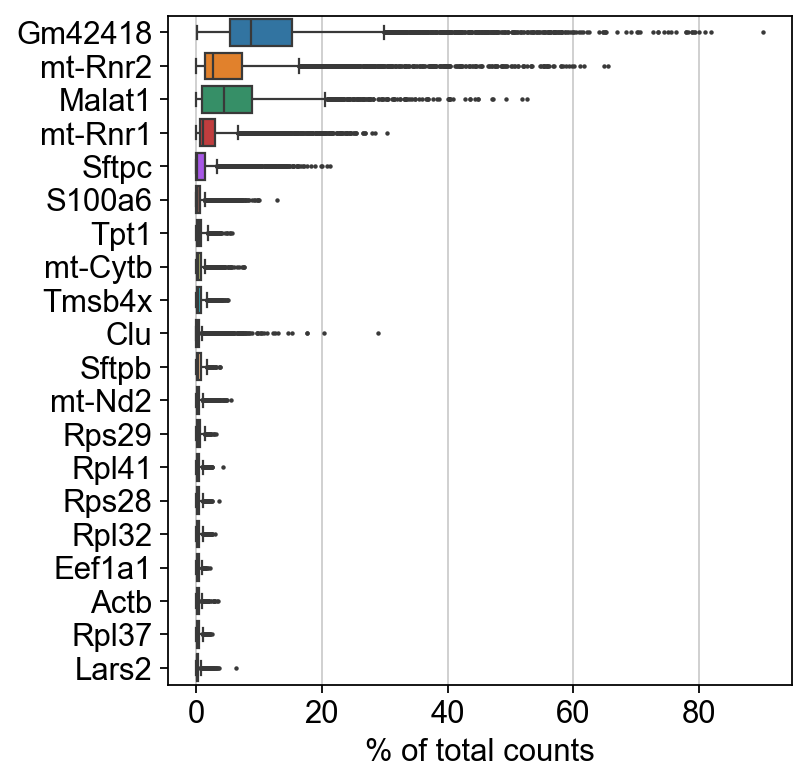

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [13]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 107 cells that have less than 1500 counts
filtered out 72 cells that have less than 300 genes expressed
filtered out 30743 genes that are detected in less than 3 cells


In [14]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

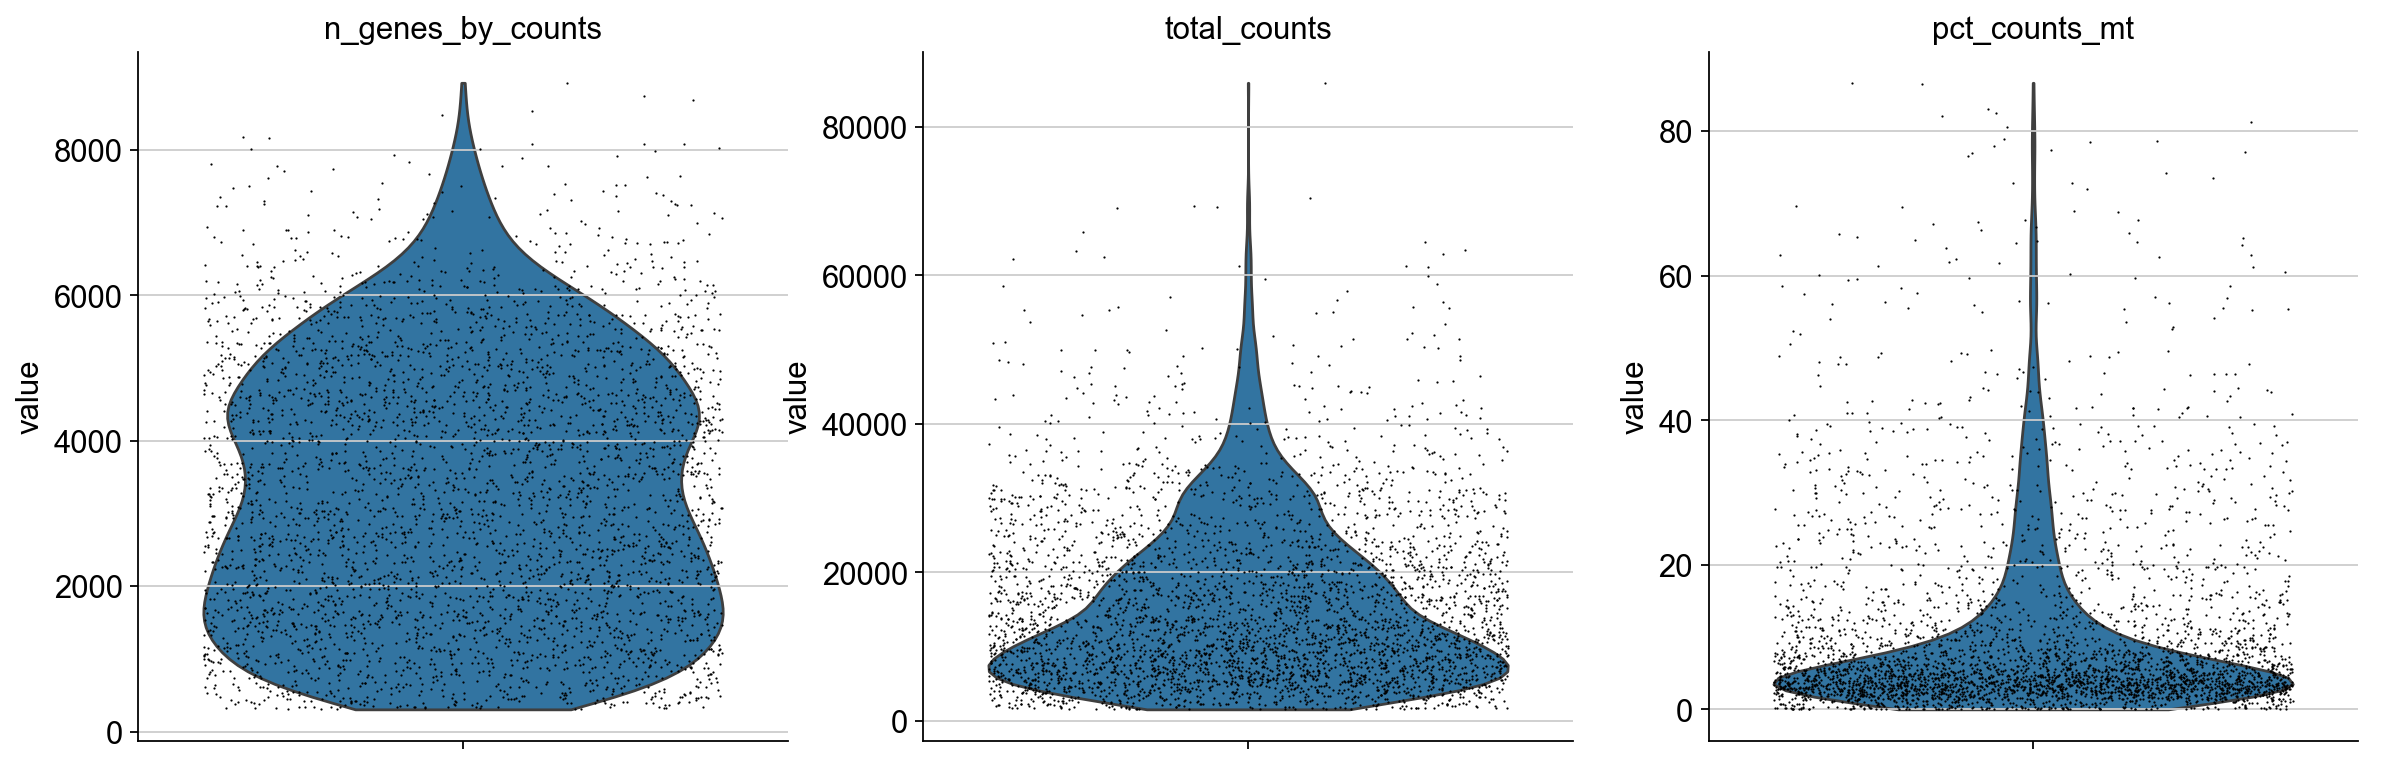

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([   7.,   15.,   39.,   67.,  181.,  393., 1321., 1505.,  277.,
          25.]),
 array([0.63998945, 0.66964132, 0.69929319, 0.72894505, 0.75859692,
        0.78824879, 0.81790065, 0.84755252, 0.87720439, 0.90685626,
        0.93650812]),
 <BarContainer object of 10 artists>)

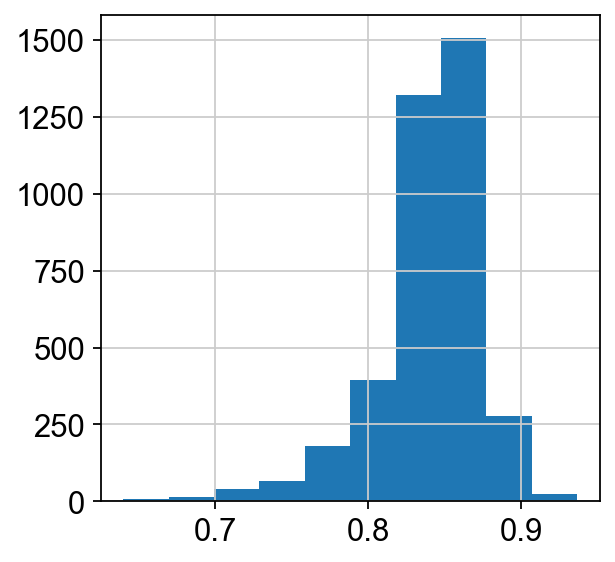

In [16]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

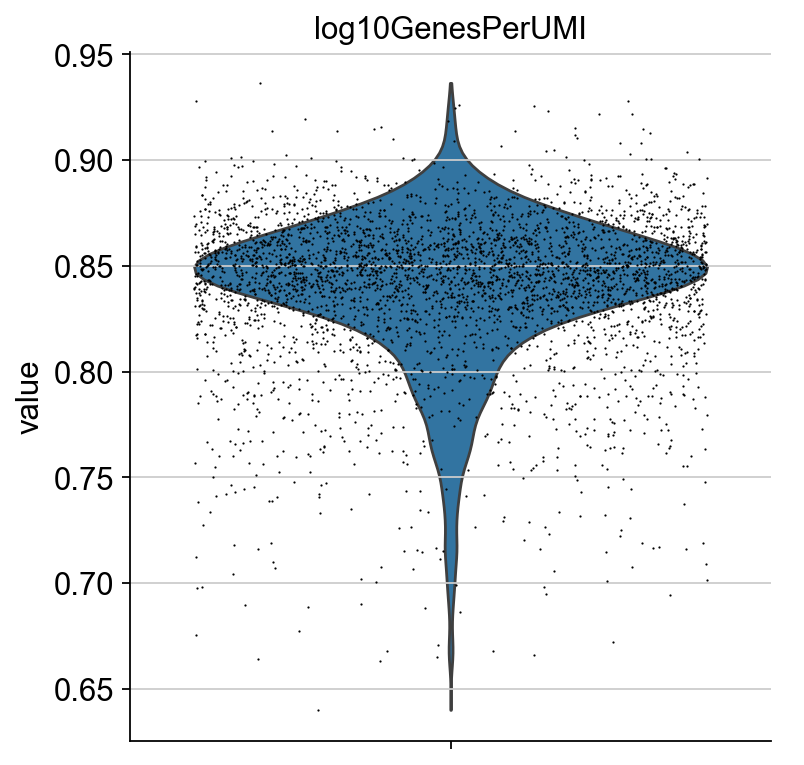

In [17]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)
#99% seems like a good Human pct count cutoff

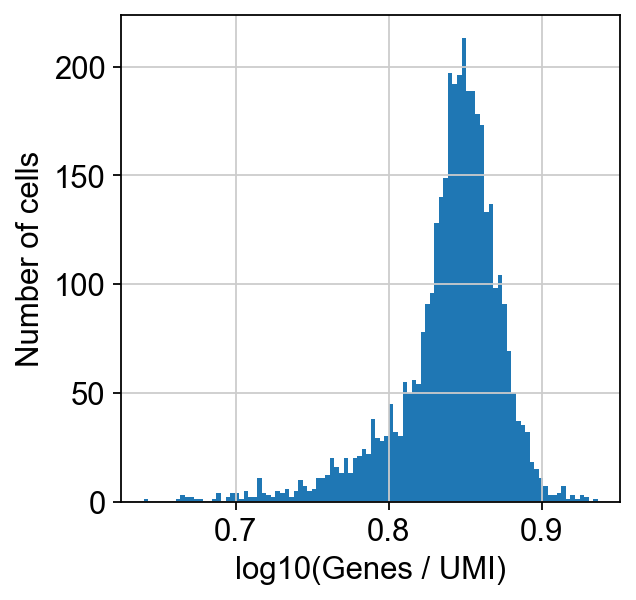

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(adata.obs["log10GenesPerUMI"], bins=100)
plt.xlabel("log10(Genes / UMI)")
plt.ylabel("Number of cells")
plt.show()


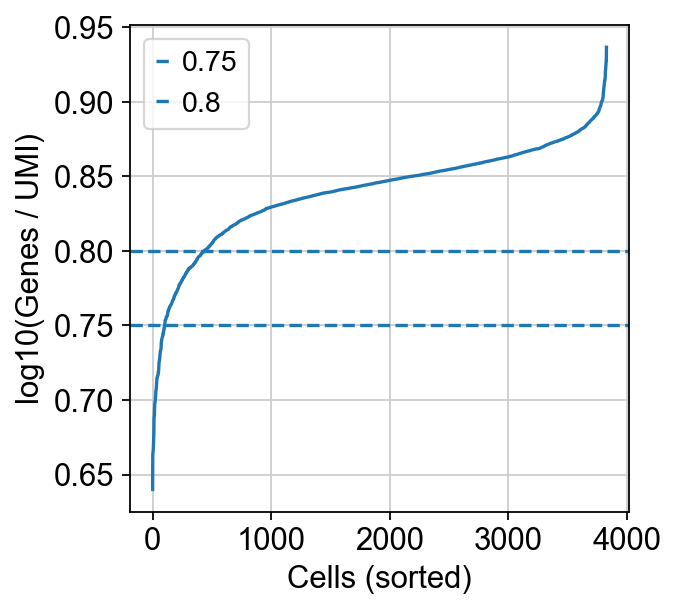

In [19]:
import numpy as np
import matplotlib.pyplot as plt

vals = np.sort(adata.obs["log10GenesPerUMI"].values)

plt.figure()
plt.plot(vals)
plt.xlabel("Cells (sorted)")
plt.ylabel("log10(Genes / UMI)")
plt.axhline(0.75, linestyle="--", label="0.75")
plt.axhline(0.8, linestyle="--", label="0.8")
plt.legend()
plt.show()


Keep singlets, remove cells that have too many mouse reads, or mitochondrial genes expressed or too many total counts:

In [20]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [21]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [22]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [23]:
hashadata.var_names

Index(['AT1939_B0301_Renilla', 'AT1940_B0302_Renilla', 'AT1944_B0303_2117',
       'AT1129_B0304_2117', 'AT1606_B0305_Renilla', 'AT1831_B0306_2117',
       'AT1607_B0307_Renilla', 'BA1525_B0308_2118', 'BA1526_B0309_2118',
       'AV1189_B0310_2118'],
      dtype='object')

In [24]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [25]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

AT1939_B0301_Renilla  AT1940_B0302_Renilla  AT1944_B0303_2117  \
count           2975.000000           2975.000000        2975.000000   
mean             290.727386            772.112915         751.902832   
std             2047.436646           4100.925293        3804.578125   
min                0.000000              0.000000           0.000000   
10%                2.000000              8.000000           4.000000   
20%                3.000000             11.000000           6.000000   
30%                4.000000             13.000000           7.000000   
40%                4.000000             15.000000           9.000000   
50%                5.000000             17.000000          10.000000   
60%                6.000000             19.000000          11.000000   
70%                7.000000             22.000000          13.000000   
80%                9.000000             27.000000          16.000000   
90%               13.000000             48.600000          30.600000   
99%            10688.300000          22242.880000       19820.320000   
max            37970.000000          62683.000000       60581.000000   

       AT1129_B0304_2117  AT1606_B0305_Renilla  AT1831_B0306_2117  \
count        2975.000000           2975.000000        2975.000000   
mean           52.641010            162.049744          19.443026   
std           722.321533           1831.993896         440.306244   
min             0.000000              0.000000           0.000000   
10%             0.000000              0.000000           0.000000   
20%             0.000000              1.000000           0.000000   
30%             0.000000              1.000000           0.000000   
40%             1.000000              2.000000           0.000000   
50%             1.000000              2.000000           0.000000   
60%             1.000000              3.000000           0.000000   
70%             1.000000              3.000000           1.000000   
80%             2.000000              4.000000           1.000000   
90%             3.000000              6.000000           2.000000   
99%            21.260000           1666.760000           6.000000   
max         18714.000000          44222.000000       17488.000000   

       AT1607_B0307_Renilla  BA1525_B0308_2118  BA1526_B0309_2118  \
count           2975.000000        2975.000000        2975.000000   
mean             133.847733         306.325378         339.186554   
std             1295.736572        1926.262451        1636.512817   
min                0.000000           0.000000           0.000000   
10%                0.000000           5.000000           2.000000   
20%                1.000000           6.000000           3.000000   
30%                1.000000           8.000000           4.000000   
40%                2.000000           9.000000           5.000000   
50%                2.000000          10.000000           6.000000   
60%                3.000000          12.000000           7.000000   
70%                3.000000          14.000000           9.000000   
80%                4.000000          17.000000          11.000000   
90%                6.000000          28.000000          24.000000   
99%             4868.420000        8015.520000        8146.500000   
max            33266.000000       46298.000000       26458.000000   

       AV1189_B0310_2118  
count        2975.000000  
mean          192.089752  
std          1486.694458  
min             0.000000  
10%             0.000000  
20%             1.000000  
30%             2.000000  
40%             2.000000  
50%             3.000000  
60%             3.000000  
70%             4.000000  
80%             5.000000  
90%             8.000000  
99%          6782.040000  
max         30649.000000

In [26]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

AT1939_B0301_Renilla
13.0
AT1940_B0302_Renilla
48.59999999999991
AT1944_B0303_2117
30.59999999999991
AT1129_B0304_2117
3.0
AT1606_B0305_Renilla
6.0
AT1831_B0306_2117
2.0
AT1607_B0307_Renilla
6.0
BA1525_B0308_2118
28.0
BA1526_B0309_2118
24.0
AV1189_B0310_2118
8.0


/tmp/ipykernel_2324080/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_2324080/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_2324080/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please exp

AT1939_B0301_Renilla  AT1940_B0302_Renilla  \
AAACGAAAGTAATTGG-1                 False                 False   
AAACGAAAGTGTACCT-1                 False                 False   
AAACGAAGTATCGCTA-1                 False                 False   
AAACGAAGTCACGACC-1                 False                  True   
AAACGAAGTTTATGCG-1                 False                 False   
...                                  ...                   ...   
TTTGGTTAGCGGACAT-1                 False                 False   
TTTGGTTGTGACAACG-1                 False                 False   
TTTGGTTGTTCTTCAT-1                 False                 False   
TTTGTTGAGGCTTAAA-1                  True                 False   
TTTGTTGCAGCTATAC-1                 False                 False   

                    AT1944_B0303_2117  AT1129_B0304_2117  \
AAACGAAAGTAATTGG-1              False              False   
AAACGAAAGTGTACCT-1              False              False   
AAACGAAGTATCGCTA-1              False              False   
AAACGAAGTCACGACC-1              False              False   
AAACGAAGTTTATGCG-1              False              False   
...                               ...                ...   
TTTGGTTAGCGGACAT-1              False              False   
TTTGGTTGTGACAACG-1              False              False   
TTTGGTTGTTCTTCAT-1              False              False   
TTTGTTGAGGCTTAAA-1               True              False   
TTTGTTGCAGCTATAC-1              False              False   

                    AT1606_B0305_Renilla  AT1831_B0306_2117  \
AAACGAAAGTAATTGG-1                 False              False   
AAACGAAAGTGTACCT-1                 False              False   
AAACGAAGTATCGCTA-1                 False              False   
AAACGAAGTCACGACC-1                  True              False   
AAACGAAGTTTATGCG-1                 False              False   
...                                  ...                ...   
TTTGGTTAGCGGACAT-1                 False              False   
TTTGGTTGTGACAACG-1                  True              False   
TTTGGTTGTTCTTCAT-1                 False              False   
TTTGTTGAGGCTTAAA-1                  True              False   
TTTGTTGCAGCTATAC-1                 False              False   

                    AT1607_B0307_Renilla  BA1525_B0308_2118  \
AAACGAAAGTAATTGG-1                 False              False   
AAACGAAAGTGTACCT-1                 False               True   
AAACGAAGTATCGCTA-1                 False              False   
AAACGAAGTCACGACC-1                 False              False   
AAACGAAGTTTATGCG-1                 False              False   
...                                  ...                ...   
TTTGGTTAGCGGACAT-1                 False               True   
TTTGGTTGTGACAACG-1                 False              False   
TTTGGTTGTTCTTCAT-1                 False              False   
TTTGTTGAGGCTTAAA-1                 False               True   
TTTGTTGCAGCTATAC-1                 False              False   

                    BA1526_B0309_2118  AV1189_B0310_2118  
AAACGAAAGTAATTGG-1              False              False  
AAACGAAAGTGTACCT-1              False              False  
AAACGAAGTATCGCTA-1              False              False  
AAACGAAGTCACGACC-1              False               True  
AAACGAAGTTTATGCG-1               True              False  
...                               ...                ...  
TTTGGTTAGCGGACAT-1              False              False  
TTTGGTTGTGACAACG-1              False              False  
TTTGGTTGTTCTTCAT-1              False              False  
TTTGTTGAGGCTTAAA-1              False               True  
TTTGTTGCAGCTATAC-1              False              False  

[2975 rows x 10 columns]

In [27]:
from matplotlib import pyplot as plt

In [28]:
hashCounts

AT1939_B0301_Renilla  AT1940_B0302_Renilla  \
AAACGAAAGTAATTGG-1                   4.0                  12.0   
AAACGAAAGTGTACCT-1                   4.0                  13.0   
AAACGAAGTATCGCTA-1                   9.0                  15.0   
AAACGAAGTCACGACC-1                   8.0                  80.0   
AAACGAAGTTTATGCG-1                   7.0                  24.0   
...                                  ...                   ...   
TTTGGTTAGCGGACAT-1                  11.0                  22.0   
TTTGGTTGTGACAACG-1                   9.0                  22.0   
TTTGGTTGTTCTTCAT-1                   8.0                  21.0   
TTTGTTGAGGCTTAAA-1                6862.0                  34.0   
TTTGTTGCAGCTATAC-1                   6.0                  18.0   

                    AT1944_B0303_2117  AT1129_B0304_2117  \
AAACGAAAGTAATTGG-1               11.0                1.0   
AAACGAAAGTGTACCT-1               17.0                1.0   
AAACGAAGTATCGCTA-1               10.0                1.0   
AAACGAAGTCACGACC-1               20.0                3.0   
AAACGAAGTTTATGCG-1                7.0                2.0   
...                               ...                ...   
TTTGGTTAGCGGACAT-1               13.0                0.0   
TTTGGTTGTGACAACG-1               15.0                0.0   
TTTGGTTGTTCTTCAT-1                8.0                0.0   
TTTGTTGAGGCTTAAA-1               33.0                2.0   
TTTGTTGCAGCTATAC-1                4.0                0.0   

                    AT1606_B0305_Renilla  AT1831_B0306_2117  \
AAACGAAAGTAATTGG-1                   1.0                2.0   
AAACGAAAGTGTACCT-1                   1.0                0.0   
AAACGAAGTATCGCTA-1                   0.0                1.0   
AAACGAAGTCACGACC-1               14295.0                1.0   
AAACGAAGTTTATGCG-1                   1.0                1.0   
...                                  ...                ...   
TTTGGTTAGCGGACAT-1                   2.0                1.0   
TTTGGTTGTGACAACG-1                  10.0                1.0   
TTTGGTTGTTCTTCAT-1                   5.0                0.0   
TTTGTTGAGGCTTAAA-1                   8.0                0.0   
TTTGTTGCAGCTATAC-1                   3.0                1.0   

                    AT1607_B0307_Renilla  BA1525_B0308_2118  \
AAACGAAAGTAATTGG-1                   5.0               12.0   
AAACGAAAGTGTACCT-1                   2.0             5057.0   
AAACGAAGTATCGCTA-1                   1.0                4.0   
AAACGAAGTCACGACC-1                   6.0               25.0   
AAACGAAGTTTATGCG-1                   0.0               10.0   
...                                  ...                ...   
TTTGGTTAGCGGACAT-1                   1.0            11696.0   
TTTGGTTGTGACAACG-1                   1.0                5.0   
TTTGGTTGTTCTTCAT-1                   1.0                8.0   
TTTGTTGAGGCTTAAA-1                   3.0               37.0   
TTTGTTGCAGCTATAC-1                   3.0                9.0   

                    BA1526_B0309_2118  AV1189_B0310_2118  
AAACGAAAGTAATTGG-1               11.0                0.0  
AAACGAAAGTGTACCT-1                6.0                8.0  
AAACGAAGTATCGCTA-1                4.0                0.0  
AAACGAAGTCACGACC-1               12.0                9.0  
AAACGAAGTTTATGCG-1              201.0                4.0  
...                               ...                ...  
TTTGGTTAGCGGACAT-1                9.0                6.0  
TTTGGTTGTGACAACG-1                4.0                3.0  
TTTGGTTGTTCTTCAT-1                1.0                0.0  
TTTGTTGAGGCTTAAA-1               10.0                9.0  
TTTGTTGCAGCTATAC-1                2.0                4.0  

[2975 rows x 10 columns]

In [29]:
plt.rcParams['figure.figsize'] = (4,4)

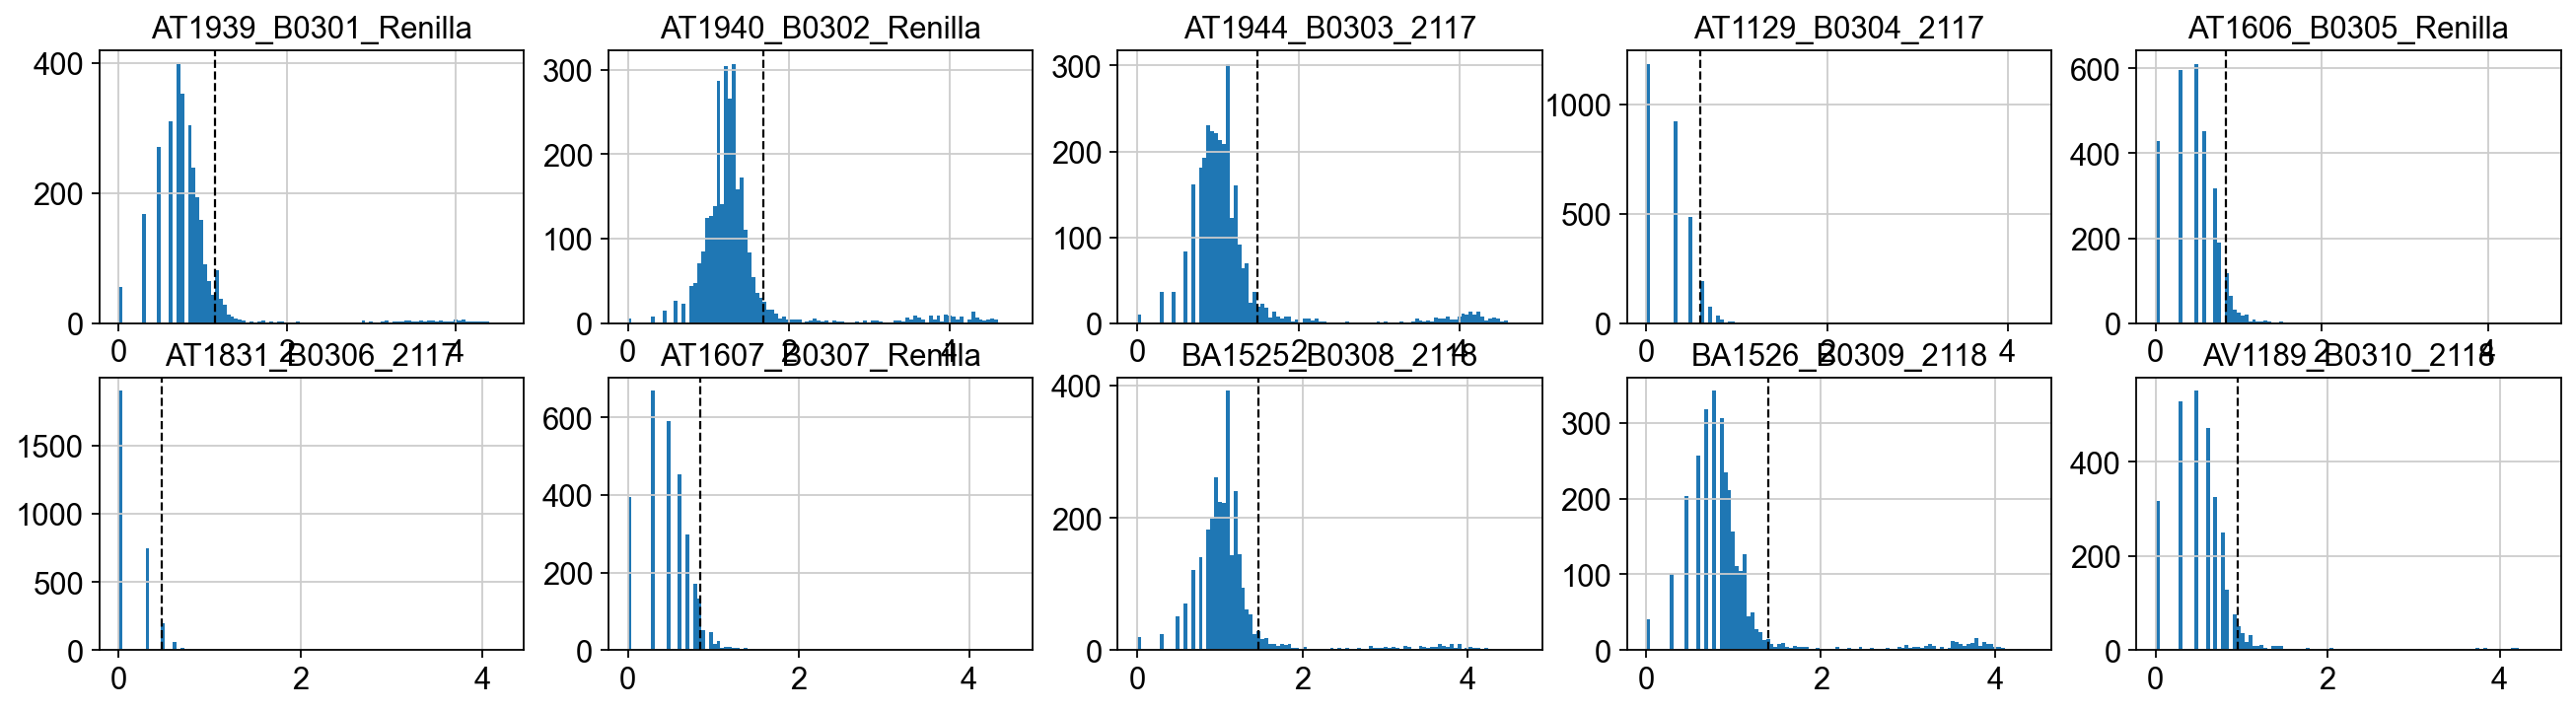

In [30]:
fig, axs = plt.subplots(2,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

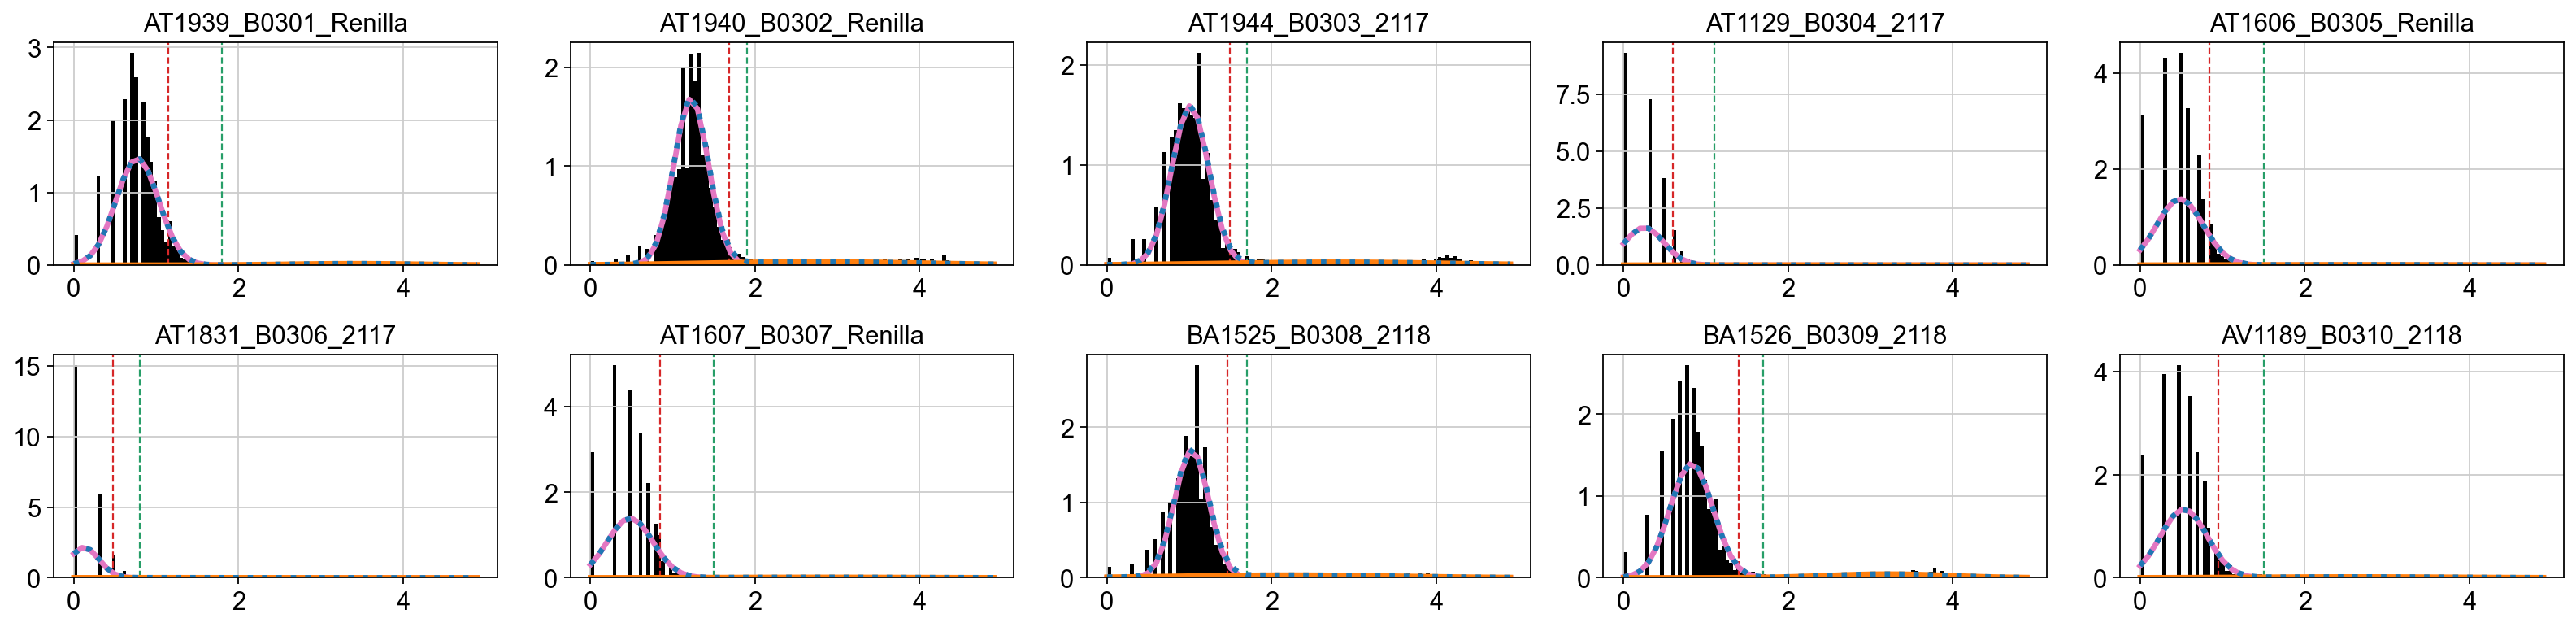

In [31]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    if mean[0][0] < mean[1][0]:
        left_idx, right_idx = 0, 1
    else:
        left_idx, right_idx = 1, 0

    
    x_axis = np.arange(0, 5, 0.1)
    
    y_left = norm.pdf(x_axis, float(mean[left_idx][0]), np.sqrt(float(covs[left_idx][0][0]))) * weights[left_idx]
    y_right = norm.pdf(x_axis, float(mean[right_idx][0]), np.sqrt(float(covs[right_idx][0][0]))) * weights[right_idx]

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]  

    diff = y_right - y_left
    crossings = np.where(np.diff(np.sign(diff)) > 0)[0]  # where right overtakes left
    
    if len(crossings) > 0:
        # Take the first crossing where right becomes dominant
        idx = crossings[0]
        hashBoundry = x_axis[idx + 1]  # slightly to the right
    else:
        # If no intersection found, fall back to right mean or a fixed value
        hashBoundry = float(mean[right_idx][0])

    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_left, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_right, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_left+y_right, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [32]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 1
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 1 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

AT1939_B0301_Renilla
1.8
1.8
AT1940_B0302_Renilla
1.9000000000000001
1.9000000000000001
AT1944_B0303_2117
1.7000000000000002
1.7000000000000002
AT1129_B0304_2117
1.1
1.1
AT1606_B0305_Renilla
1.5
1.5
AT1831_B0306_2117
0.8
1.0
AT1607_B0307_Renilla
1.5
1.5
BA1525_B0308_2118
1.7000000000000002
1.7000000000000002
BA1526_B0309_2118
1.7000000000000002
1.7000000000000002
AV1189_B0310_2118
1.5
1.5


/tmp/ipykernel_2324080/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_2324080/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_2324080/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' ha

In [33]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    #print(i)
    #print(hashBool)
    #print(hashBool.values)
    #print(sum(hashBool))
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [34]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/tmp/ipykernel_2324080/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/tmp/ipykernel_2324080/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
negative                1787
BA1526_B0309_2118        187
AT1940_B0302_Renilla     185
AT1944_B0303_2117        176
BA1525_B0308_2118        166
doublet                  147
AV1189_B0310_2118         97
AT1939_B0301_Renilla      94
AT1607_B0307_Renilla      50
AT1606_B0305_Renilla      42
AT1129_B0304_2117         31
AT1831_B0306_2117         13
Name: count, dtype: int64

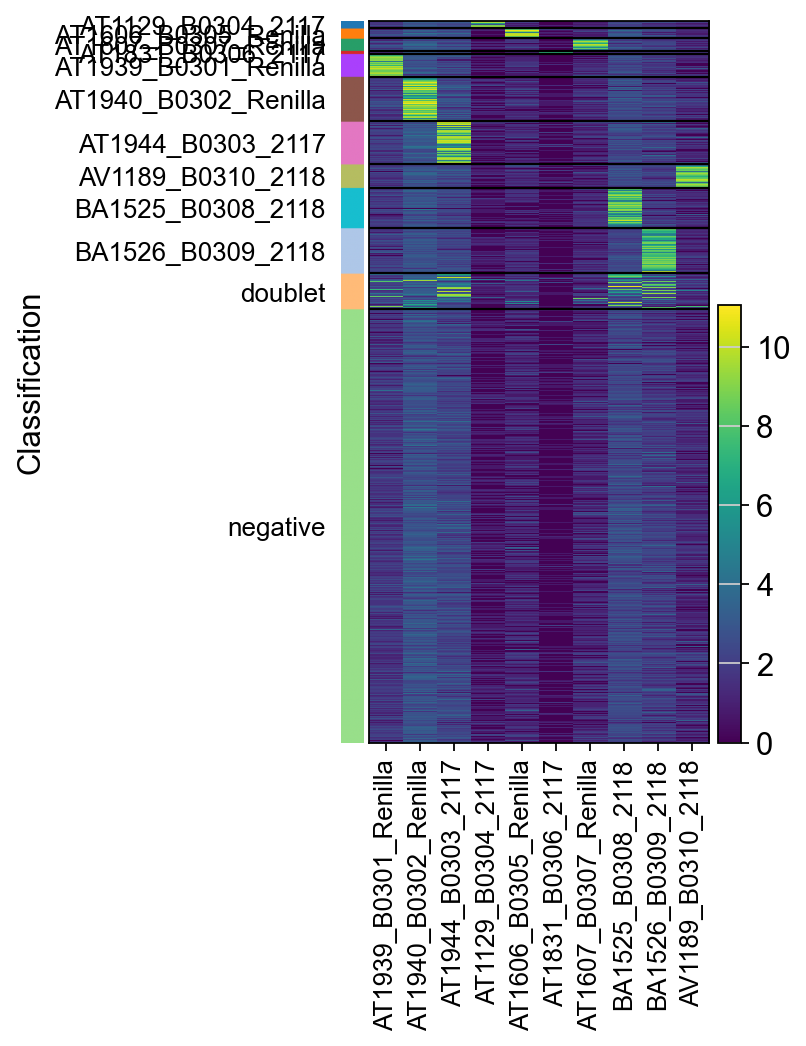

In [35]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set specialized gene counts

In [36]:
adata.var.index

Index(['Xkr4', 'Gm37180', 'Gm19938', 'Rp1', 'Gm37483', 'Gm22307', 'Gm37323',
       'Gm6085', 'Gm6119', 'Mrpl15',
       ...
       'AC168977.1', 'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1', 'GFP',
       'Cre', 'mKate2', '2117-Nfkb1.2331', '2118-Nfkb1.3737', 'shRenilla'],
      dtype='object', length=24130)

(array([2.923e+03, 1.900e+01, 4.000e+00, 1.400e+01, 2.000e+00, 4.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 1.000e+00]),
 array([ 0.        ,  4.5999999 ,  9.19999981, 13.79999924, 18.39999962,
        23.        , 27.59999847, 32.20000076, 36.79999924, 41.39999771,
        46.        ]),
 <BarContainer object of 10 artists>)

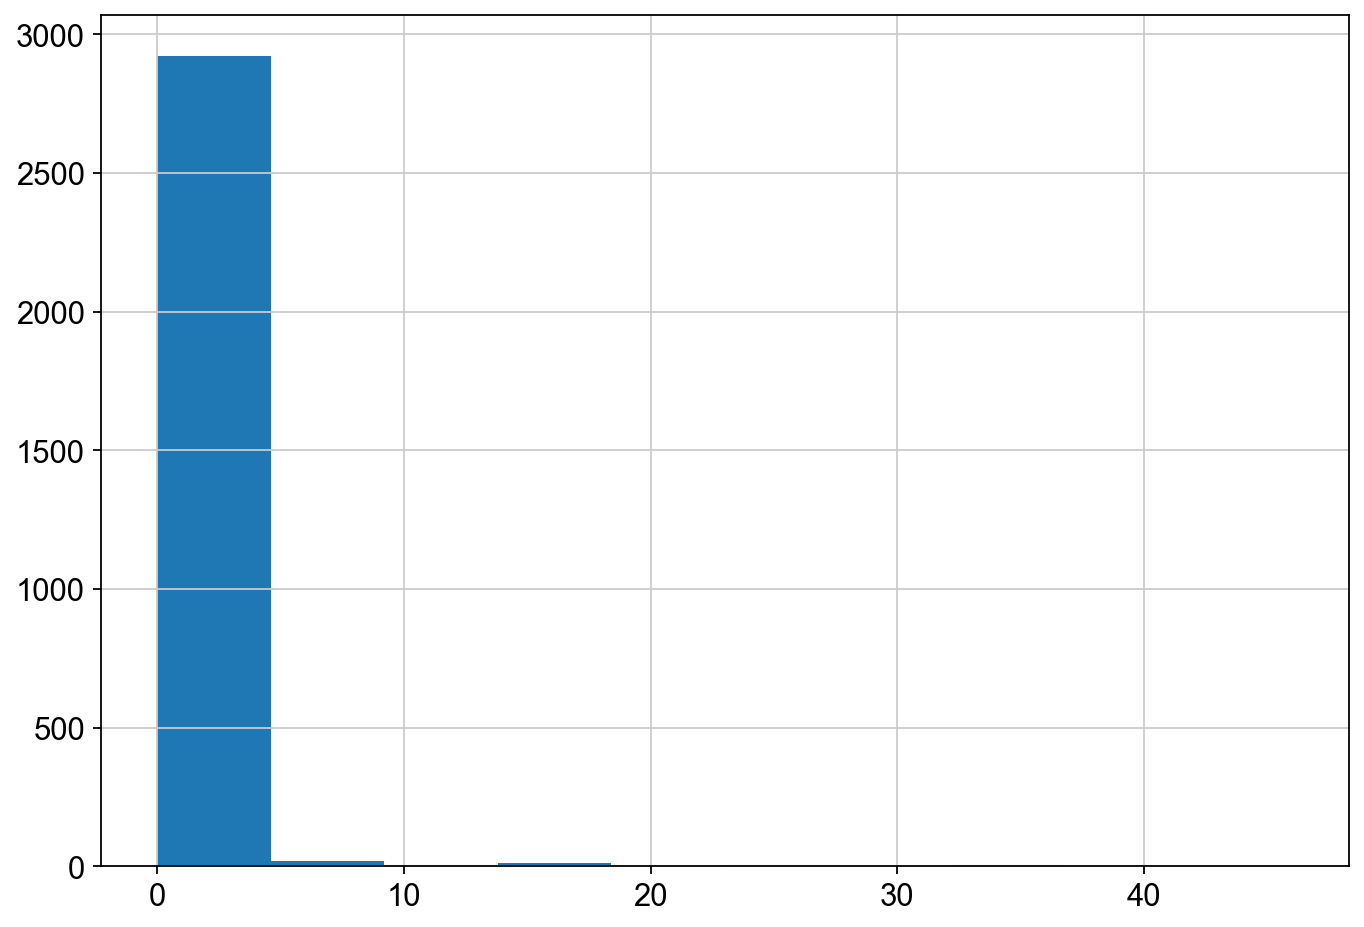

In [37]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['shRenilla'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['shRen'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [38]:
adata.obs['shRen'] = adata.X[:,adata.var.index.isin(['shRenilla'])].toarray()

(array([2.947e+03, 1.300e+01, 5.000e+00, 3.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  6.4000001 , 12.80000019, 19.20000076, 25.60000038,
        32.        , 38.40000153, 44.79999924, 51.20000076, 57.60000229,
        64.        ]),
 <BarContainer object of 10 artists>)

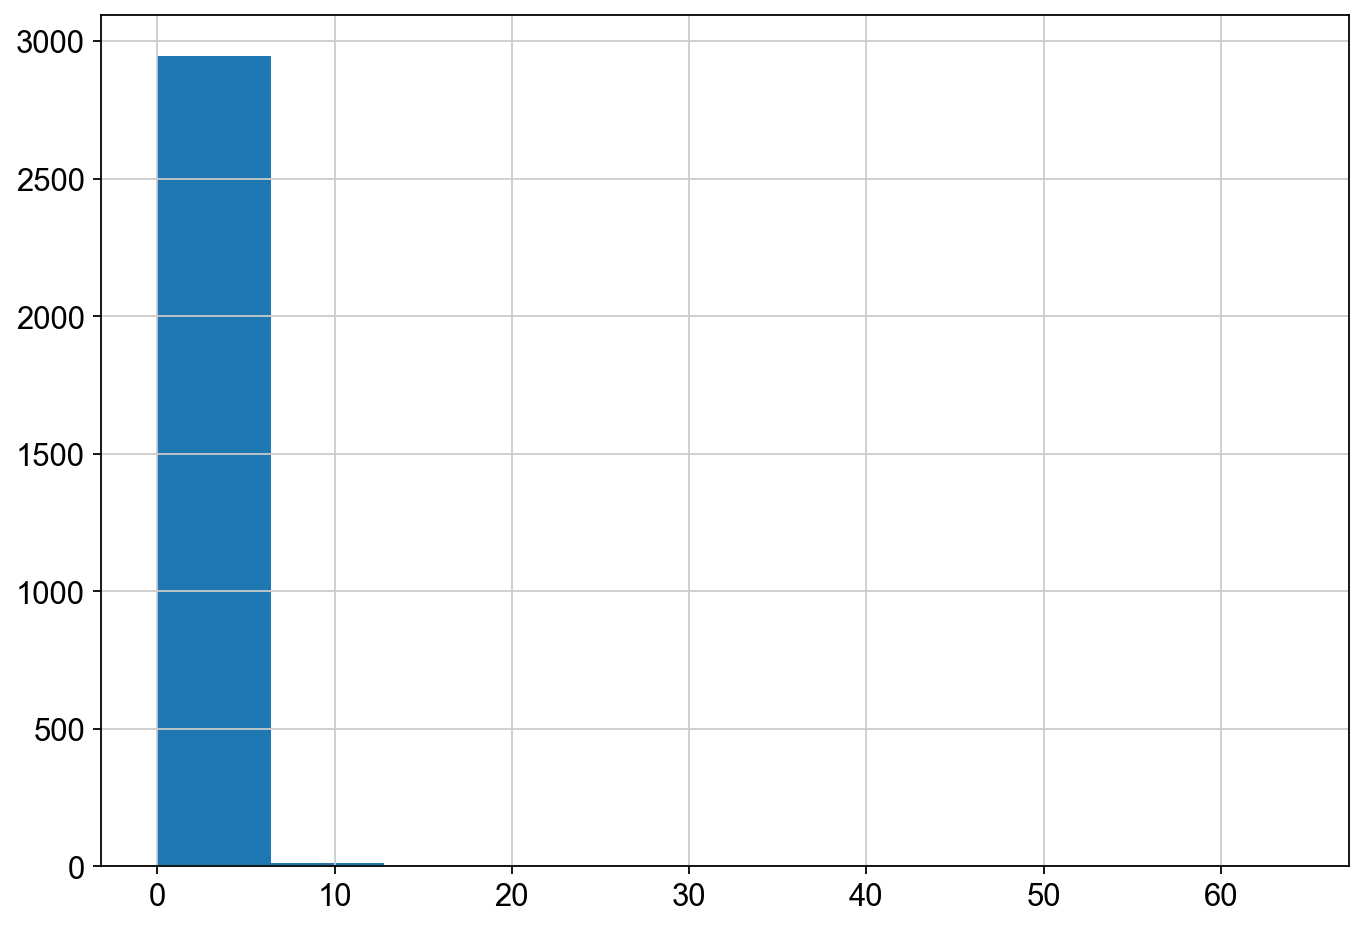

In [39]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['2118-Nfkb1.3737'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [40]:
adata.obs['2118-Nfkb1'] = adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray()

(array([2.948e+03, 1.000e+01, 5.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.        ,  3.79999995,  7.5999999 , 11.39999962, 15.19999981,
        19.        , 22.79999924, 26.60000038, 30.39999962, 34.20000076,
        38.        ]),
 <BarContainer object of 10 artists>)

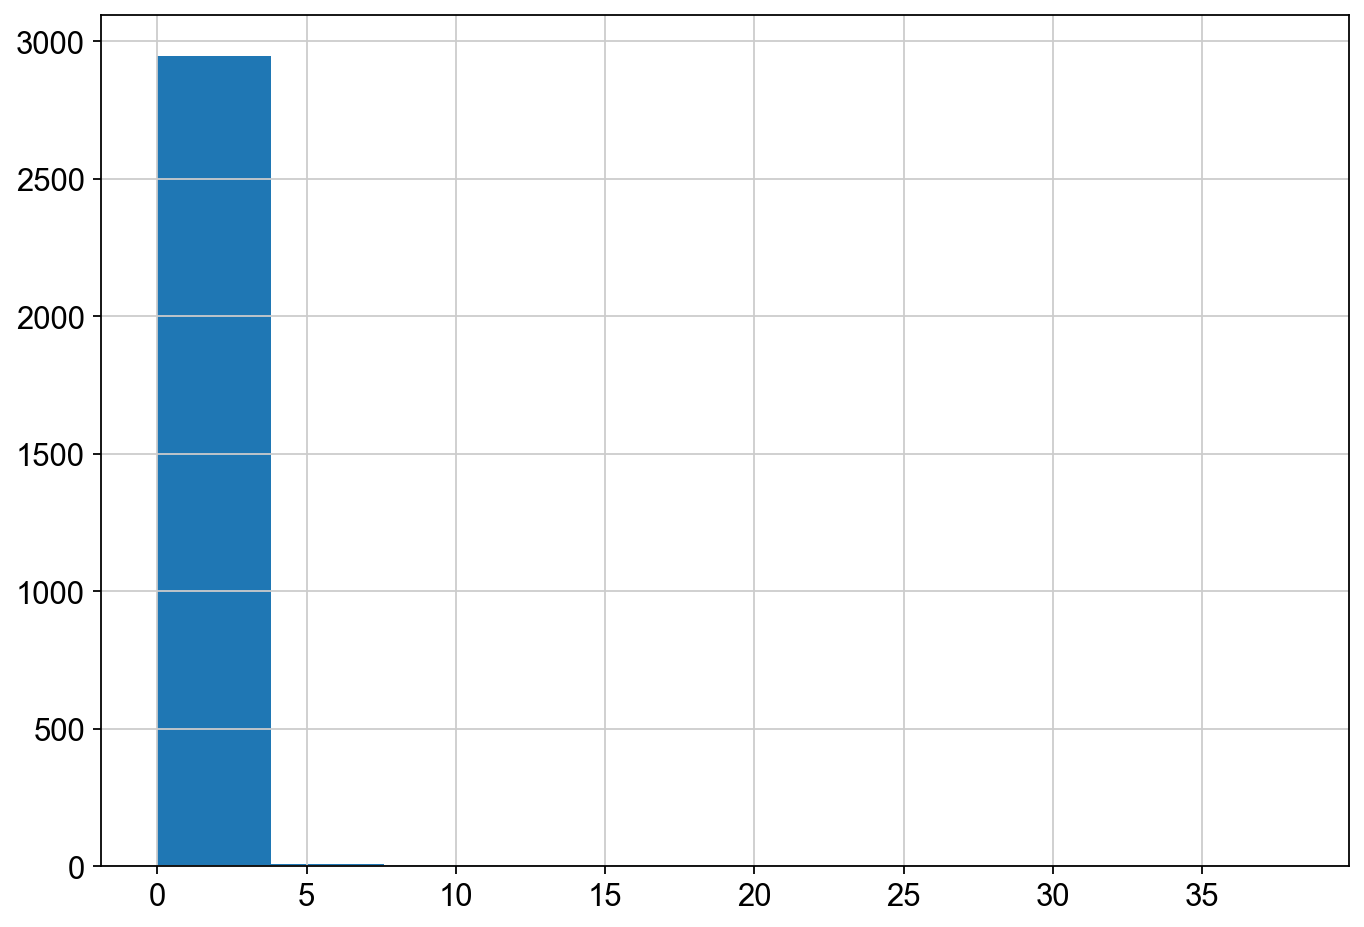

In [41]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2117-Nfkb1.2331'])].toarray())

In [42]:
adata.obs['2117-Nfkb1'] = adata.X[:,adata.var.index.isin(['2117-Nfkb1.2331'])].toarray()

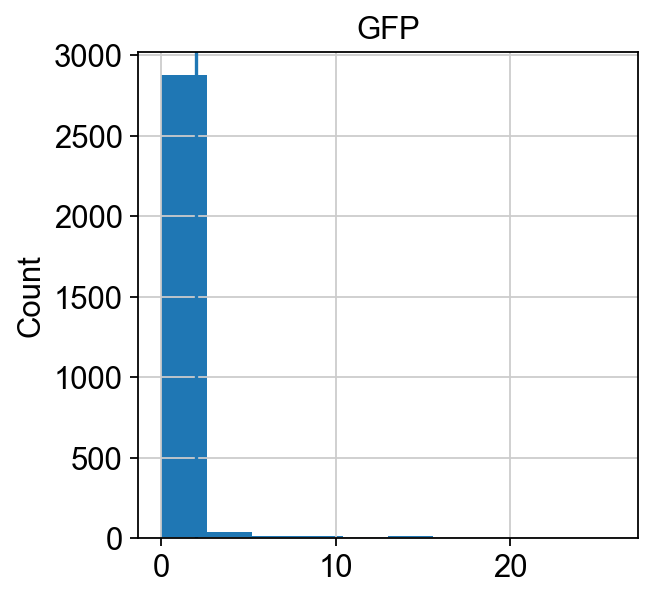

In [43]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'GFP'].X.toarray())
plt.ylabel("Count")
plt.title("GFP")
plt.axvline(x=2)
plt.show()

In [44]:
adata.obs['GFP_count'] = adata.X[:,adata.var.index.isin(['GFP'])].toarray()

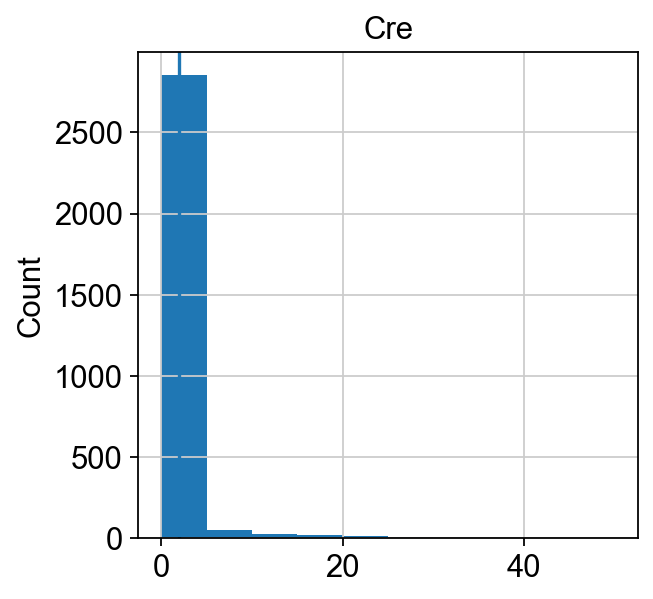

In [45]:
import matplotlib.pyplot as plt
_ = plt.hist(adata[adata.obs.index,'Cre'].X.toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [46]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

## Filter doublets and negative cells

In [47]:
adata.obs.Classification.value_counts()

Classification
negative                1787
BA1526_B0309_2118        187
AT1940_B0302_Renilla     185
AT1944_B0303_2117        176
BA1525_B0308_2118        166
doublet                  147
AV1189_B0310_2118         97
AT1939_B0301_Renilla      94
AT1607_B0307_Renilla      50
AT1606_B0305_Renilla      42
AT1129_B0304_2117         31
AT1831_B0306_2117         13
Name: count, dtype: int64

In [48]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [49]:
adata.obs.Classification.value_counts()

Classification
BA1526_B0309_2118       187
AT1940_B0302_Renilla    185
AT1944_B0303_2117       176
BA1525_B0308_2118       166
AV1189_B0310_2118        97
AT1939_B0301_Renilla     94
AT1607_B0307_Renilla     50
AT1606_B0305_Renilla     42
AT1129_B0304_2117        31
AT1831_B0306_2117        13
Name: count, dtype: int64

## Set Groups

In [50]:
#Set shRNA groups
adata.obs['shRNA'] = None
adata.obs['shRNA'][adata[adata.obs['shRen'] >= 2,:].obs.index] = 'shRenilla'
adata.obs['shRNA'][adata[adata.obs['2117-Nfkb1'] >= 2,:].obs.index] = '2117'
adata.obs['shRNA'][adata[adata.obs['2118-Nfkb1'] >= 2,:].obs.index] = '2118'

/tmp/ipykernel_2324080/4115219045.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['shRNA'] = None
/tmp/ipykernel_2324080/4115219045.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [51]:
#Set shRNA groups
adata.obs['Group'] = 'shRenilla'
adata.obs['Group'][adata.obs.Classification.isin(['AT1944_B0303_2117','AT1129_B0304_2117','AT1831_B0306_2117'])] = 'shNfkb1_2331'
adata.obs['Group'][adata.obs.Classification.isin(['BA1526_B0309_2118','BA1525_B0308_2118','AV1189_B0310_2118'])] = 'shNfkb1_3737'

/tmp/ipykernel_2324080/391155145.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['Group'][adata.obs.Classification.isin(['AT1944_B0303_2117','AT1129_B0304_2117','AT1831_B0306_2117'])] = 'shNfkb1_2331'
/tmp/ipykernel_2324080/391

In [52]:
adata.obs[['Group','Classification']].value_counts(sort=False)

Group         Classification      
shNfkb1_2331  AT1129_B0304_2117        31
              AT1831_B0306_2117        13
              AT1944_B0303_2117       176
shNfkb1_3737  AV1189_B0310_2118        97
              BA1525_B0308_2118       166
              BA1526_B0309_2118       187
shRenilla     AT1606_B0305_Renilla     42
              AT1607_B0307_Renilla     50
              AT1939_B0301_Renilla     94
              AT1940_B0302_Renilla    185
Name: count, dtype: int64

## Double check shRNAs and filter accordingly

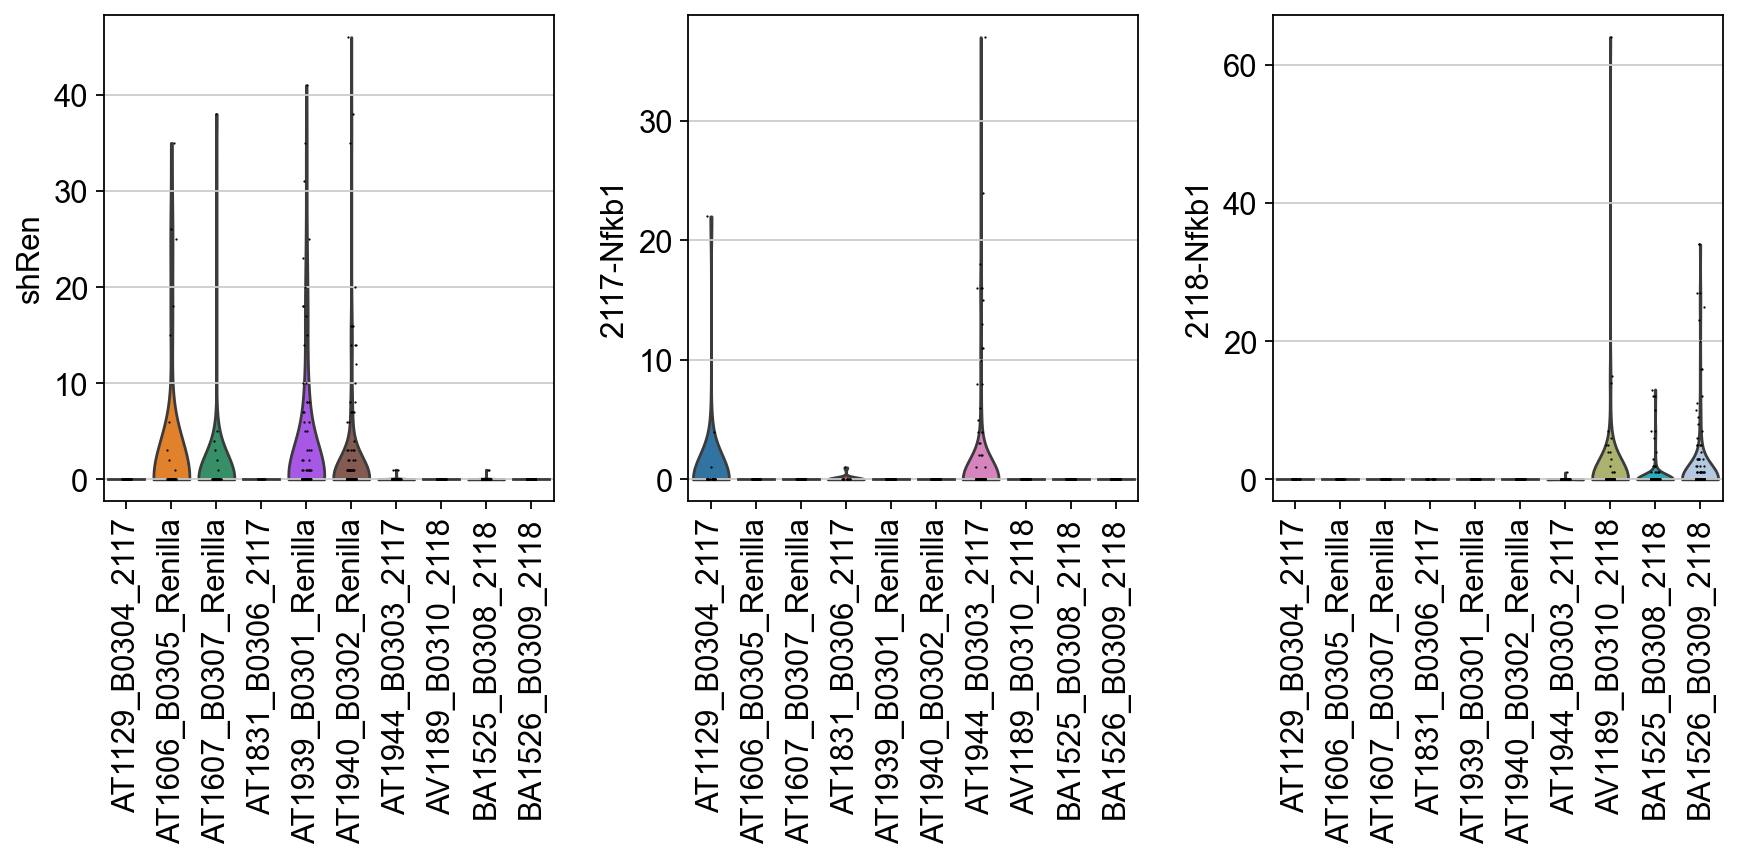

In [53]:
sc.pl.violin(adata,['shRen','2117-Nfkb1','2118-Nfkb1'], groupby='Classification', rotation=90) 

In [54]:
adata.obs[['shRNA','Group']].value_counts()

shRNA      Group       
shRenilla  shRenilla       71
2118       shNfkb1_3737    54
2117       shNfkb1_2331    25
Name: count, dtype: int64

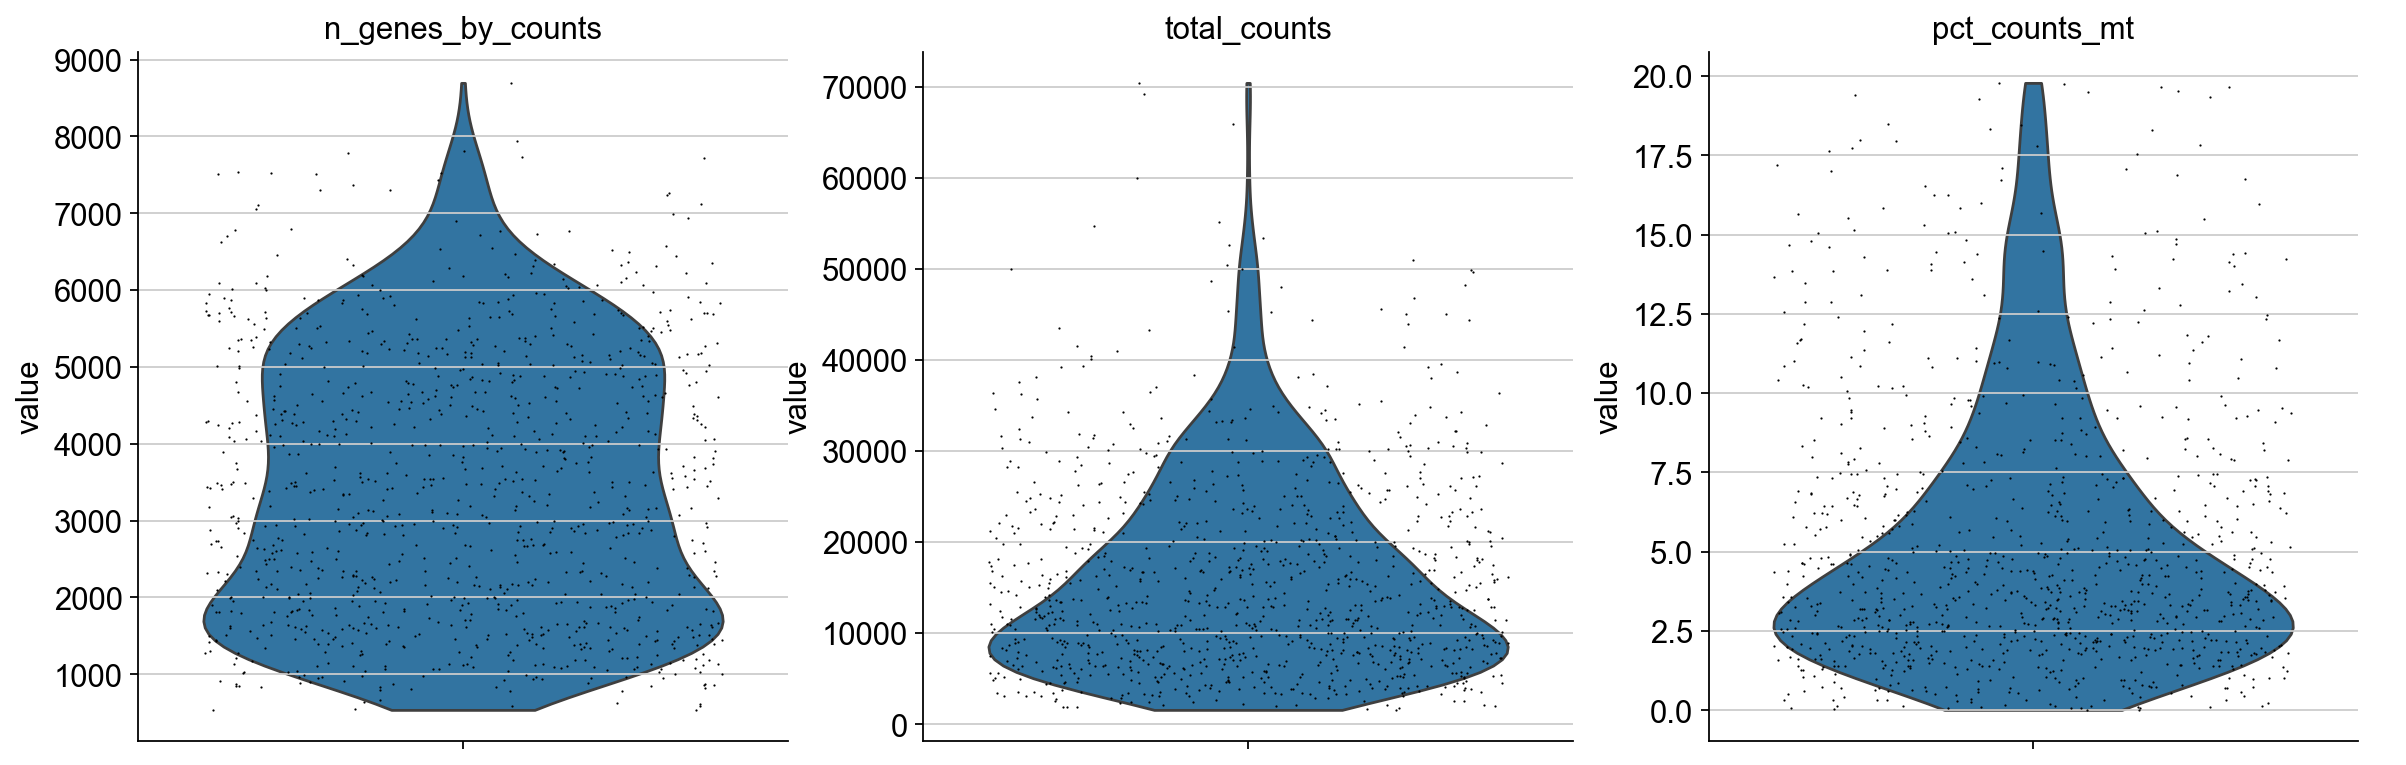

In [55]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

In [56]:
adata.layers['counts']=adata.X.copy()

In [57]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [58]:
sc.pp.log1p(adata)

In [59]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


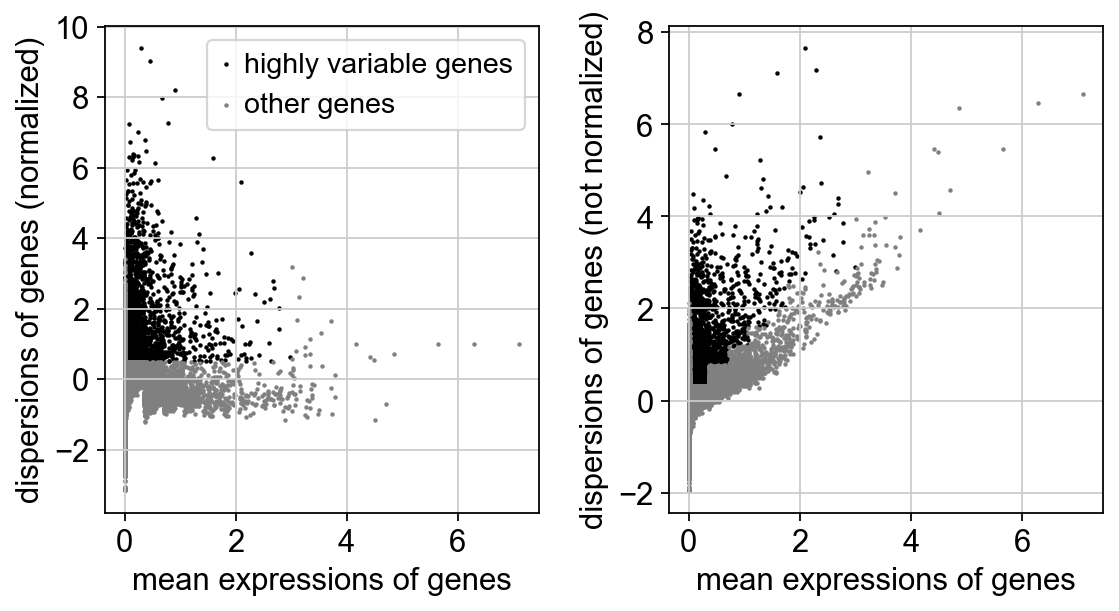

In [60]:
sc.pl.highly_variable_genes(adata)

In [61]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","2190-Jun_2481","2191-Jun_3136","2193-JunB_406","2194-JunD_78","2195-JunD_859","JCP618-Rela_1202","JCP621-Rela_1182","JCP623-Rel_1868","JCP625-Rel_342","JCP628-Ikbkg_2526","JCP629-Ikbkg_2984"]

In [62]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_2324080/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_2324080/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [63]:
adata.raw = adata

In [64]:
adata.write_h5ad('write/JC2175-allmice_lane1.h5ad', compression='gzip')

In [65]:
sc.pp.scale(adata, max_value=10)

/home/chanj2/part2a/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [66]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:00)


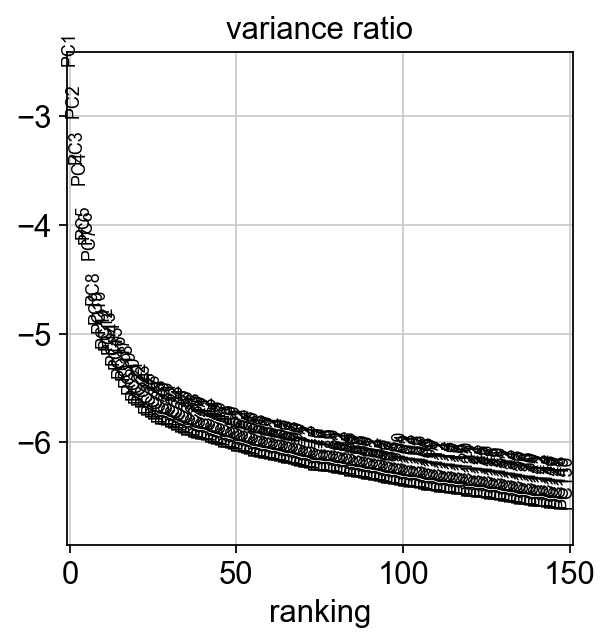

In [67]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

In [68]:
adata.write(results_file, compression='gzip')

In [69]:
adata

AnnData object with n_obs × n_vars = 1041 × 24130
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'shRen', '2118-Nfkb1', '2117-Nfkb1', 'GFP_count', 'Cre_count', 'shRNA', 'Group'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Classification_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## Computing the neighborhood graph

In [70]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/chanj2/part2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [71]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


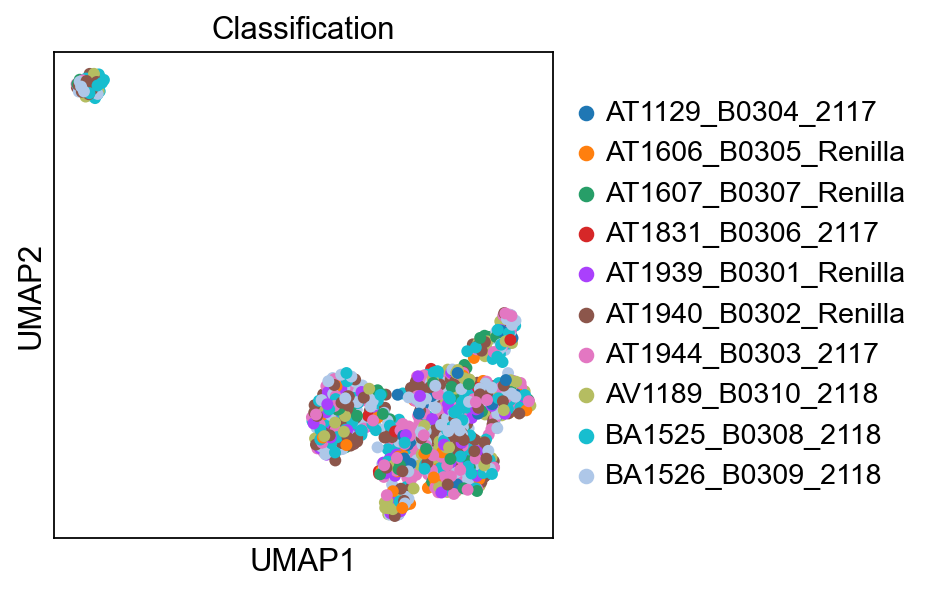

In [72]:
sc.pl.umap(adata, color=['Classification'])

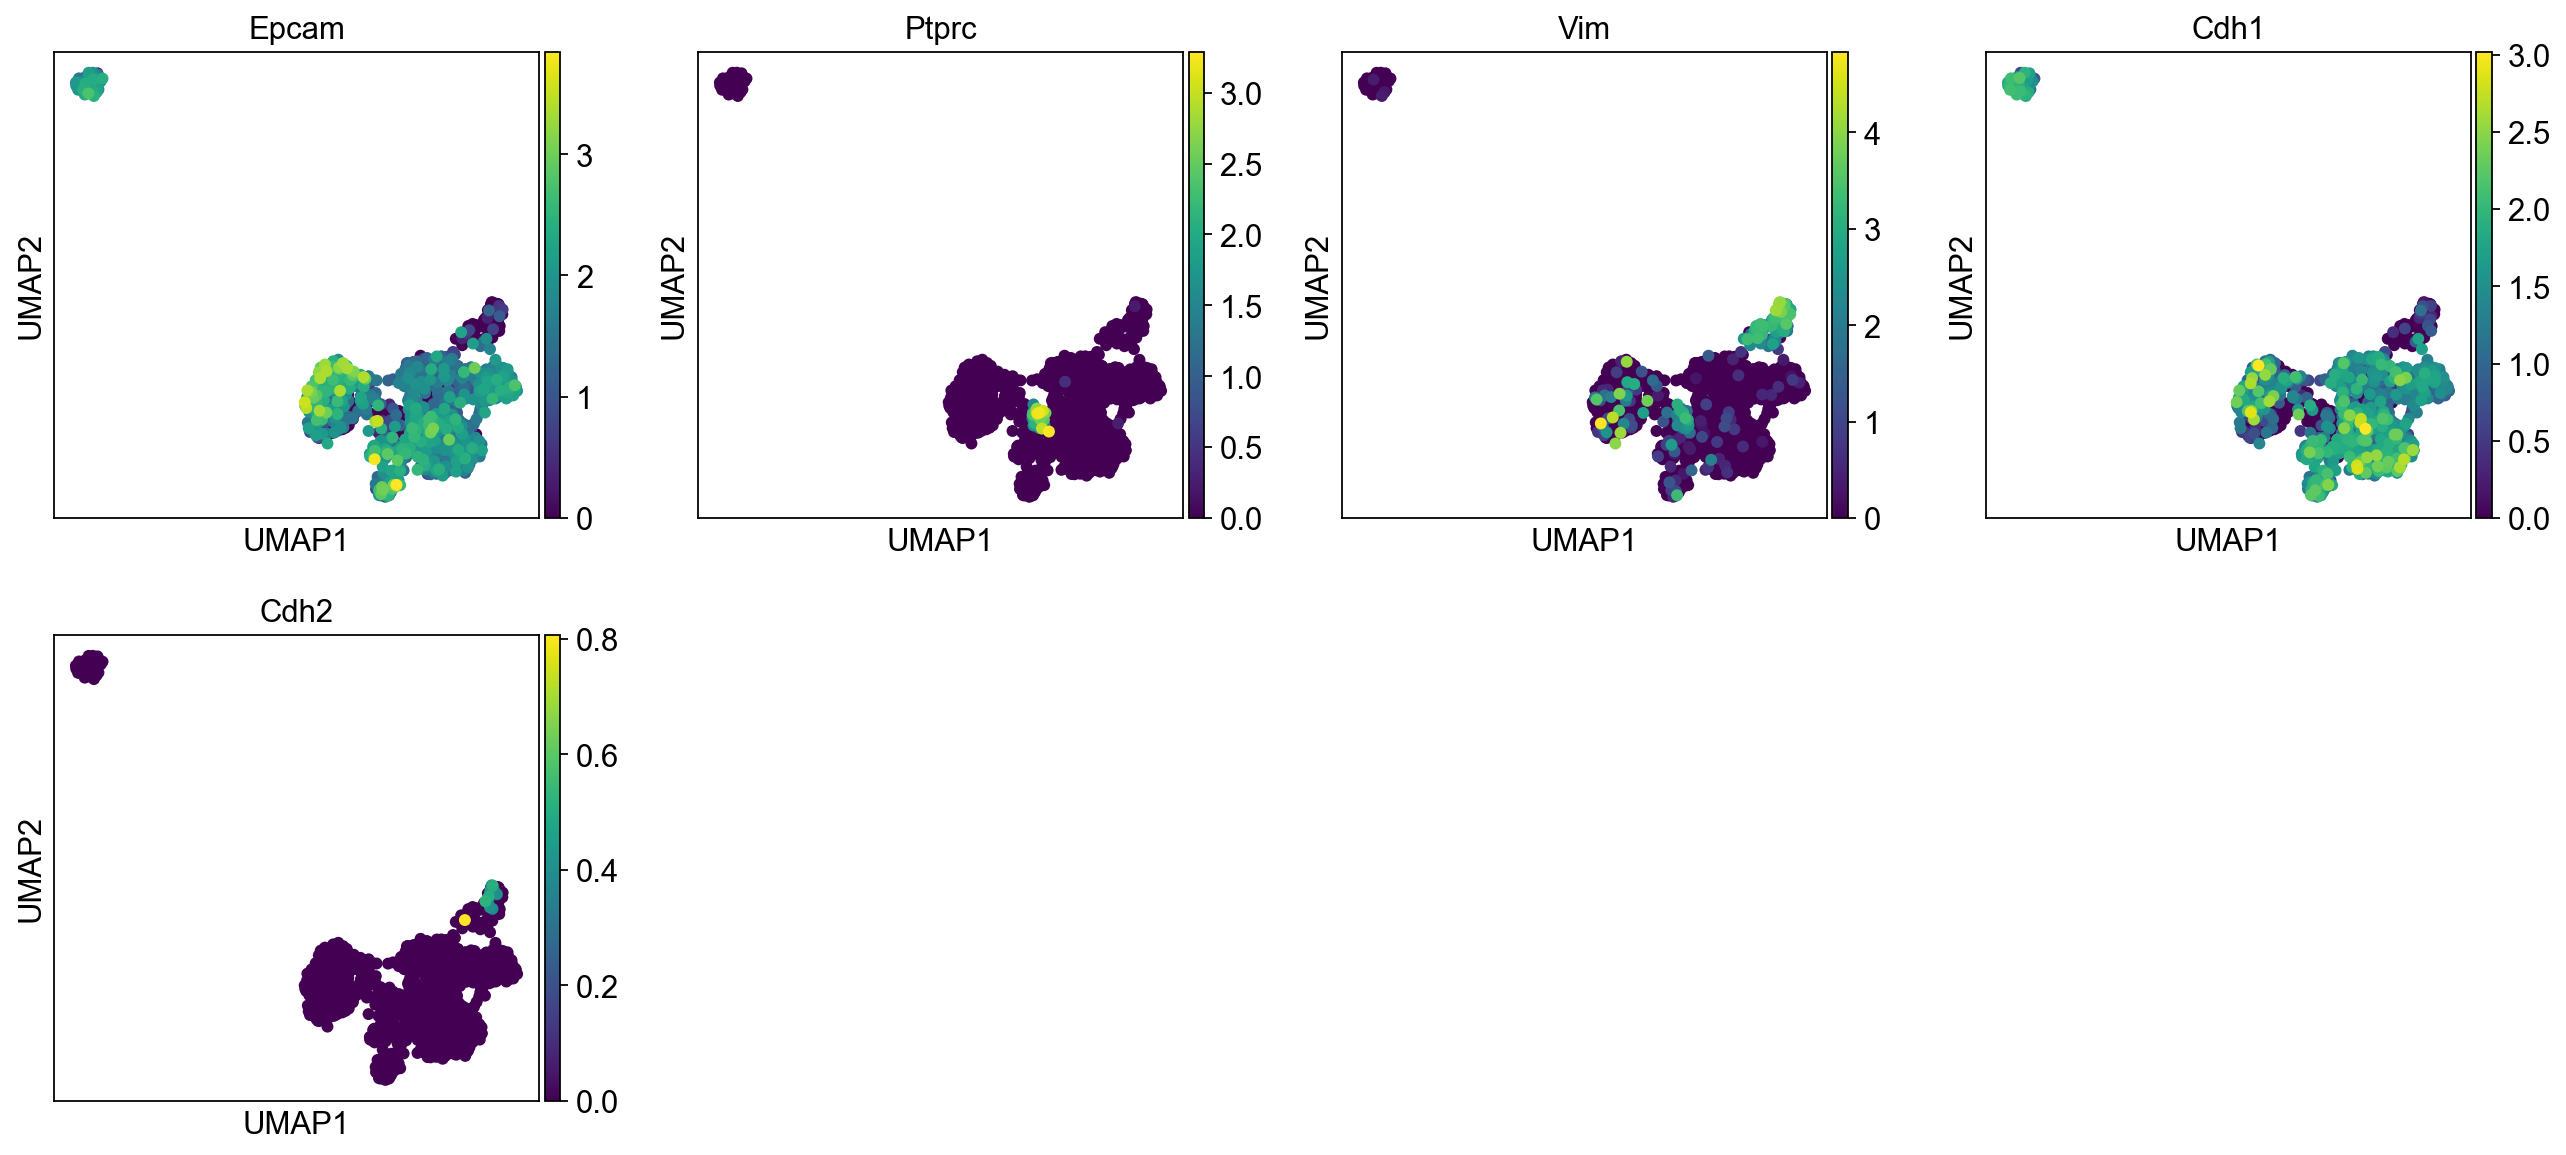

In [73]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1','Cdh2'])

In [74]:
sc.pl.umap(adata, color=['Kras','Trp53'], vmax=5)
sc.pl.umap(adata, color=['mKate2','GFP'], vmax=2)

In [75]:
sc.pl.umap(adata, color=['total_counts'])

In [76]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [77]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [78]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1792 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1599 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1490 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1395 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1787 total control genes are used. (0:00:00)
computing score 'Cluster 6'
       'Gm6139', 'Gm10179', 'Gm5864'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2192 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', scor

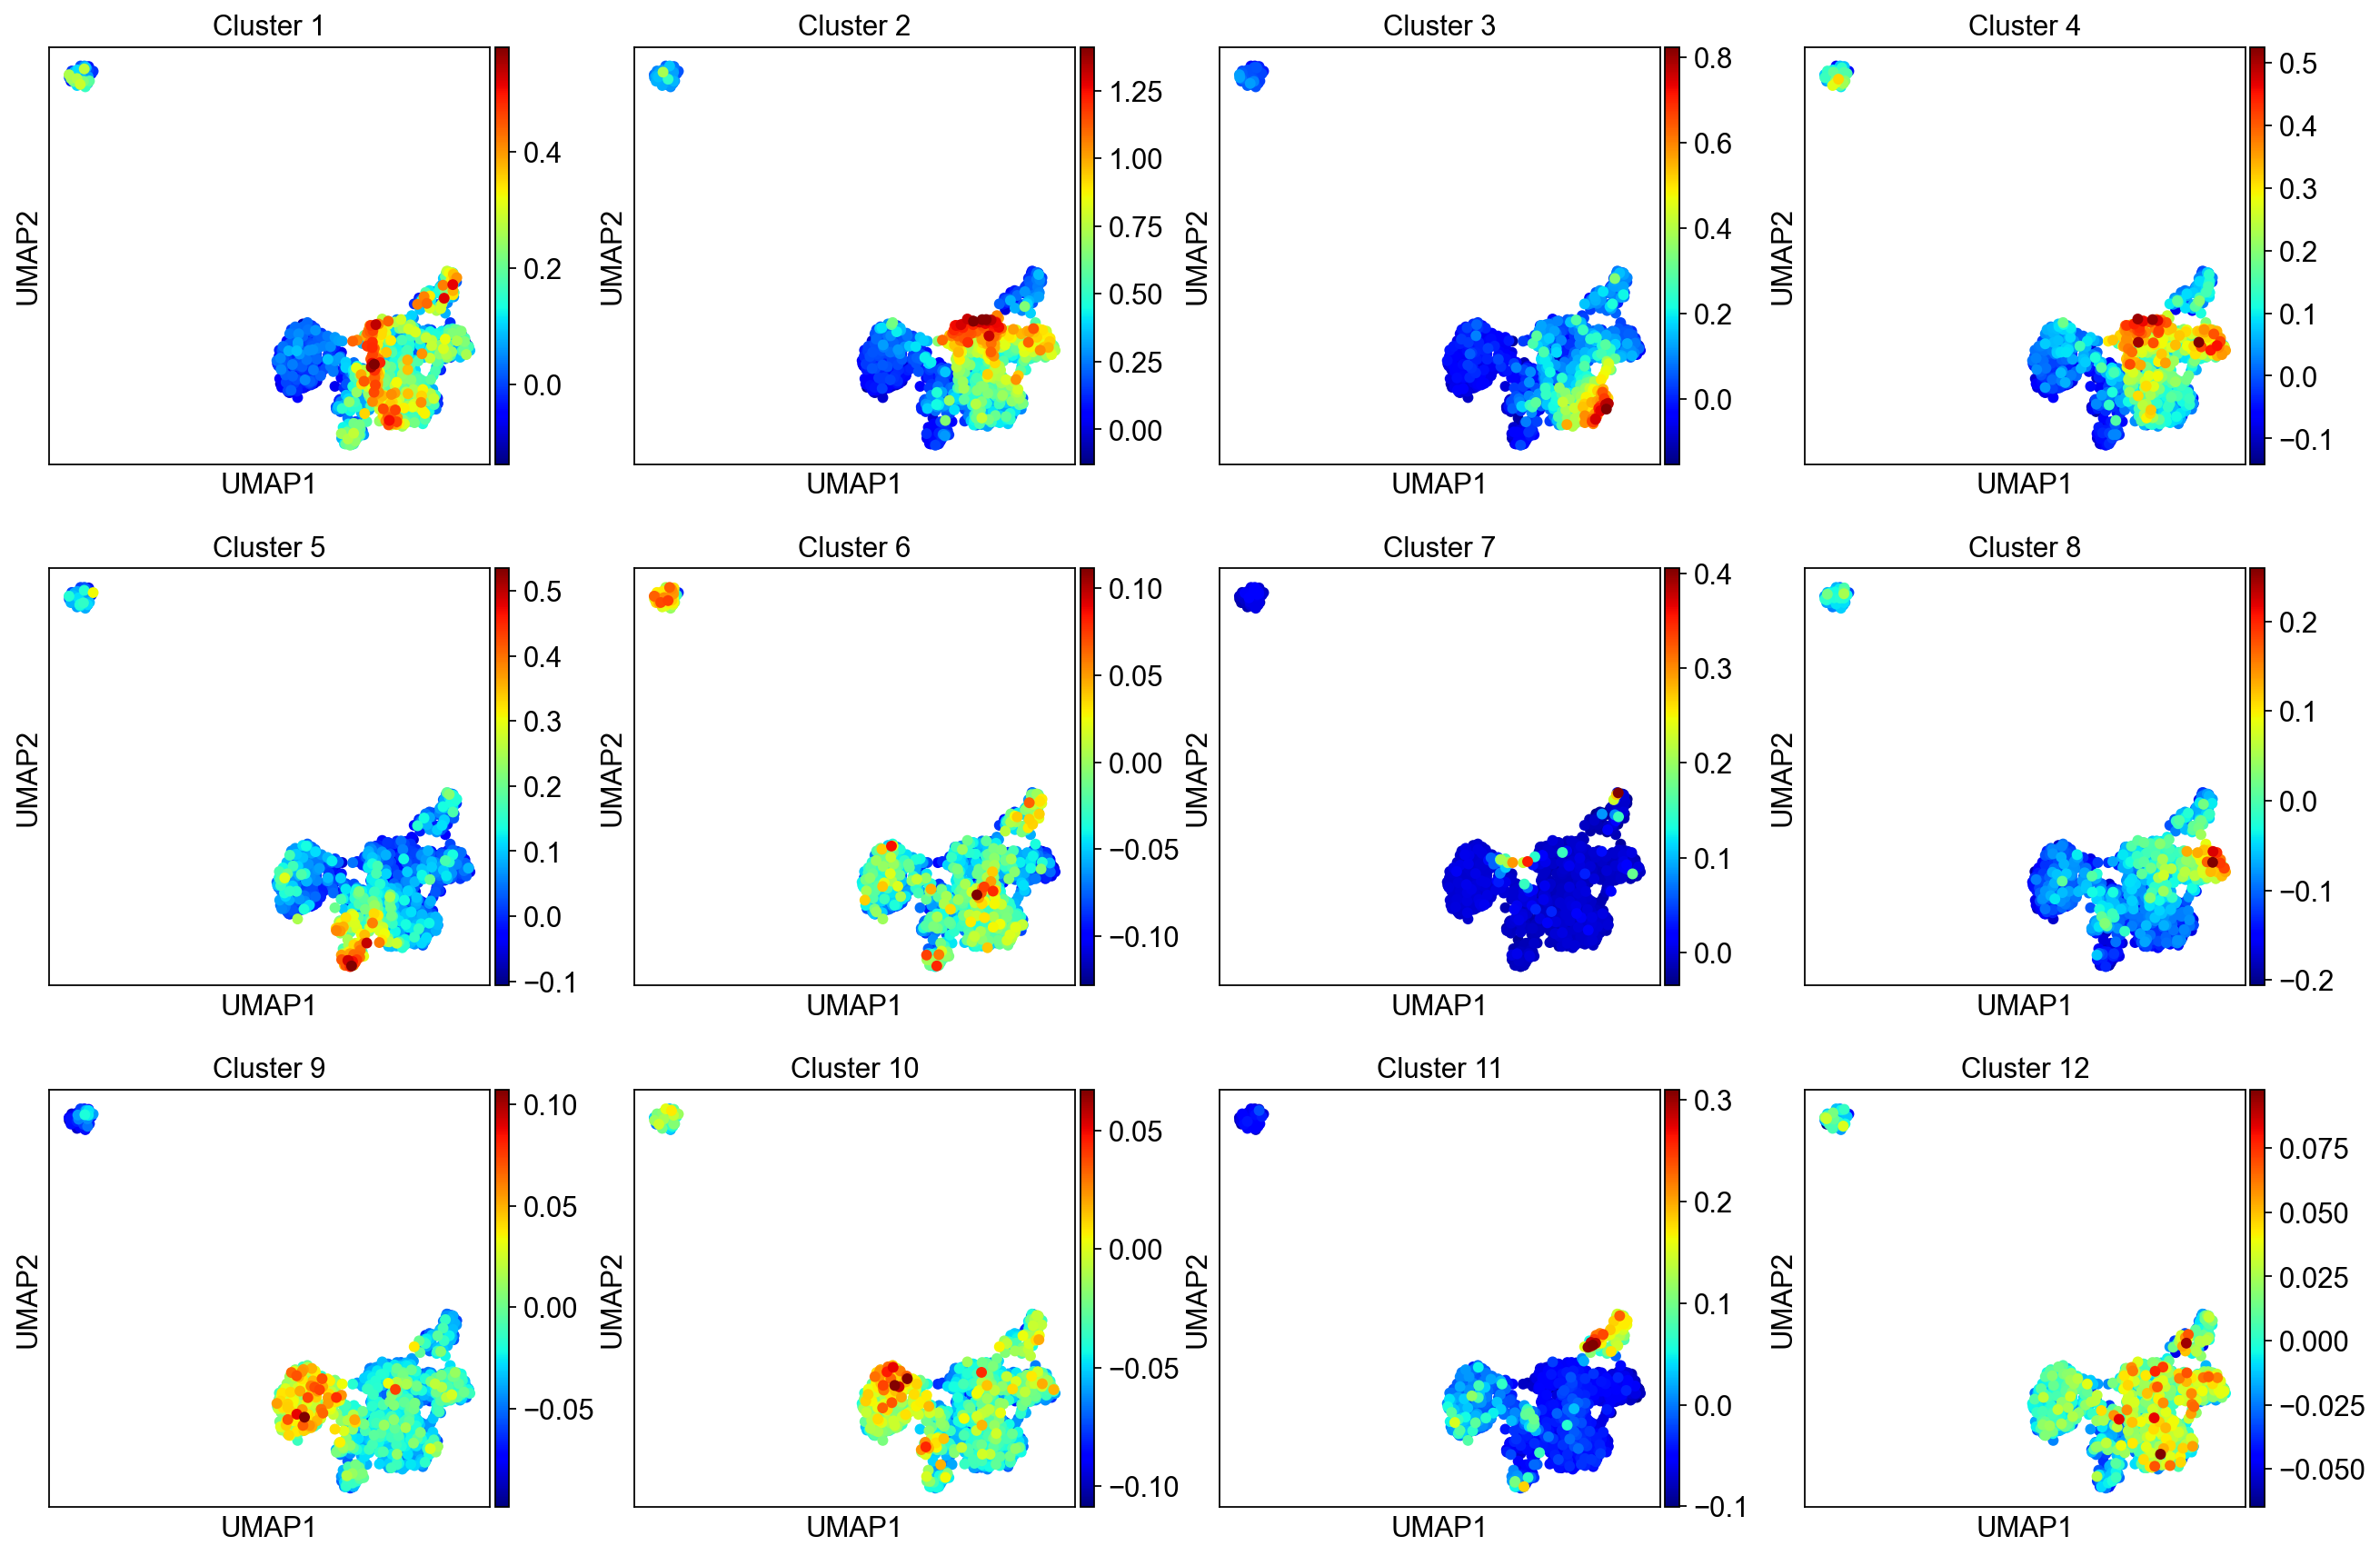

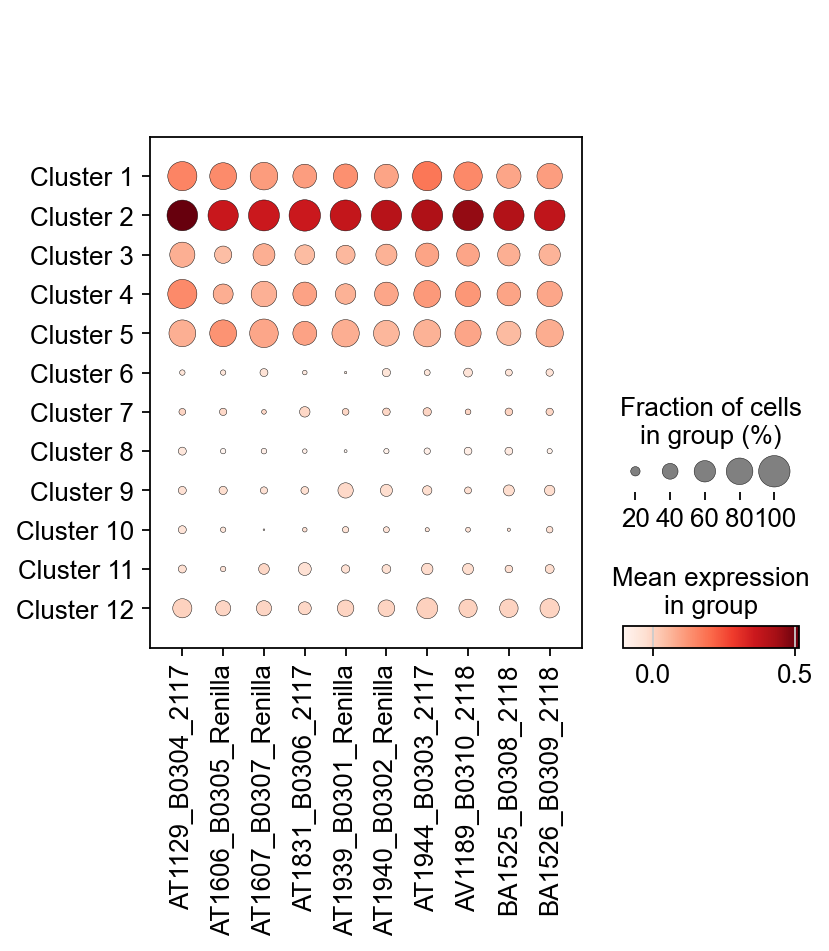

In [79]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [80]:
sc.tl.leiden(adata, resolution=1)
#sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_2324080/1382306405.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


In [81]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

(None,)

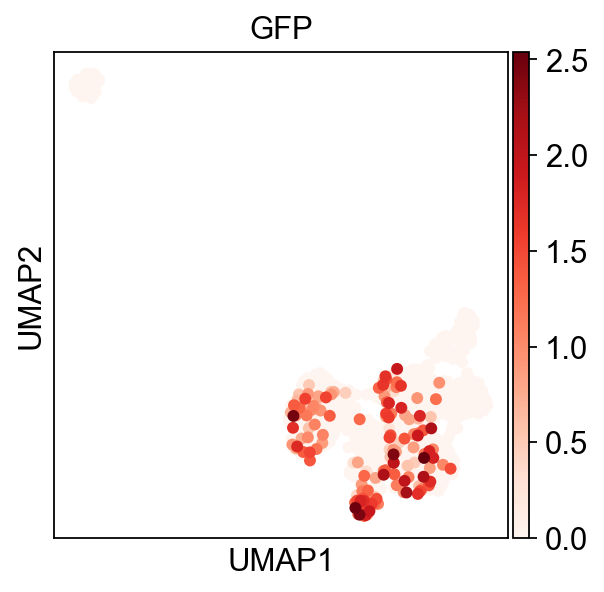

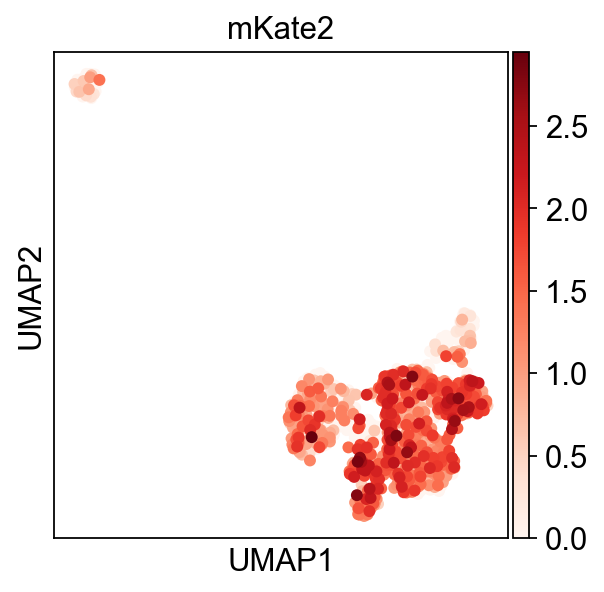

In [82]:
sc.pl.umap(adata, color=['GFP'], cmap='Reds')
sc.pl.umap(adata, color=['mKate2'], cmap='Reds')

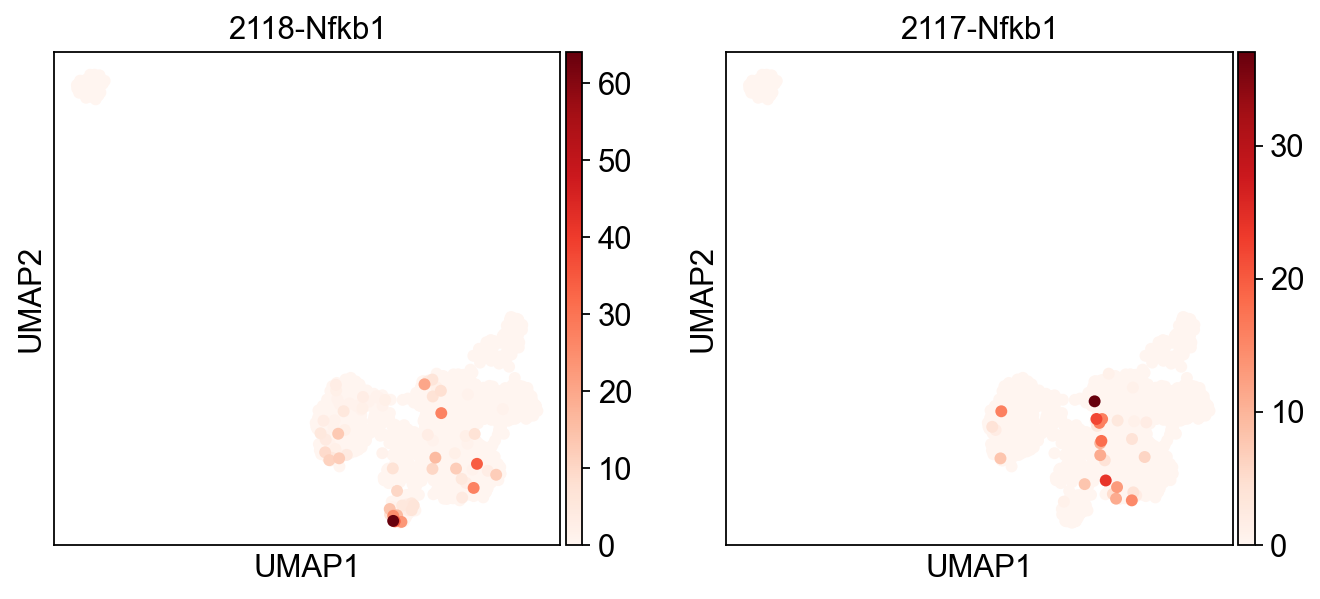

In [83]:
sc.pl.umap(adata, color=[ "2118-Nfkb1", "2117-Nfkb1"], cmap='Reds') #"shRenilla",

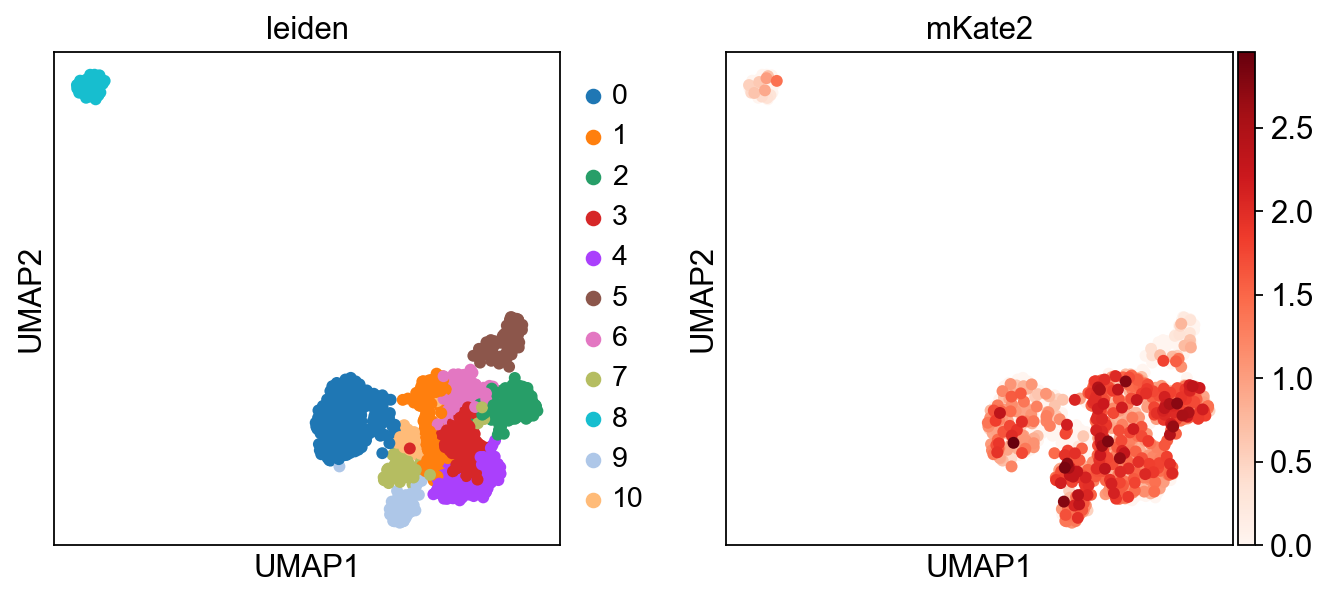

In [84]:
sc.pl.umap(adata, color=['leiden','mKate2'],cmap="Reds")

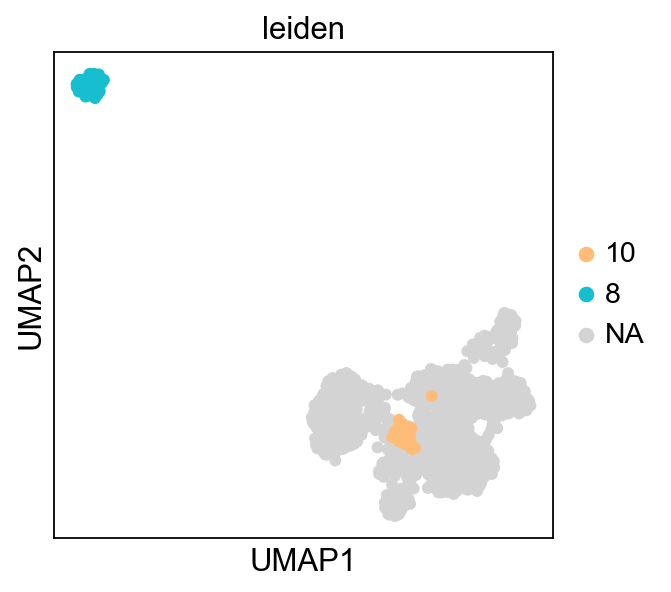

In [85]:
sc.pl.umap(adata, color=['leiden'], groups=['8','10',])

## Select Tumor Cells

In [86]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/JC2175-allmice_lane1.h5ad')
adata = adata2[~adata.obs['leiden'].isin(['8','10']),:] # keep tumor cells
del adata2

In [87]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/tmp/ipykernel_2324080/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [88]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [89]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_2324080/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_2324080/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

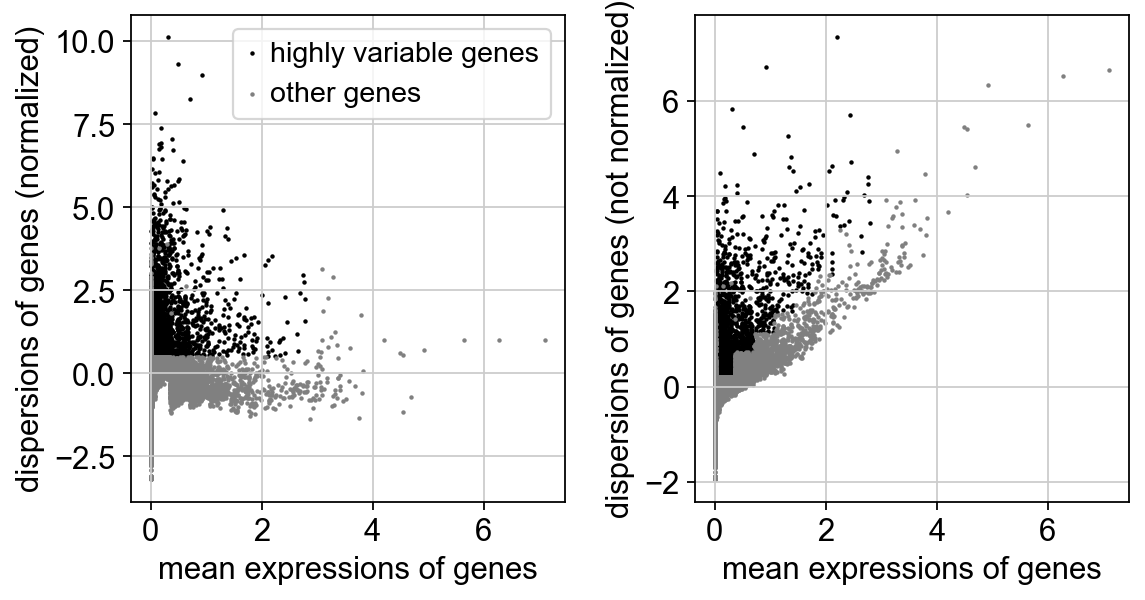

In [90]:
sc.pl.highly_variable_genes(adata)

In [91]:
adata.raw = adata

In [92]:
adata.write('write/JC2175-allmice-tumor_lane1.h5ad', compression='gzip')
#adata = sc.read('write/JC2175-allmice-tumor_lane1.h5ad')